In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast
from wordcloud import WordCloud
import seaborn as sns
from scipy.stats import skew, boxcox
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import time
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split, KFold

In [ ]:
import warnings
warnings.filterwarnings('ignore')
!pip install featuretools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 32.5 MB/s 
     |████████████████████████████████| 281 kB 32.7 MB/s 
     |████████████████████████████████| 207 kB 54.8 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
# Downloading the csv file from your GitHub account

train_url = "https://raw.githubusercontent.com/Kilenk/inputs/main/train.csv"
test_url = "https://raw.githubusercontent.com/Kilenk/inputs/main/test.csv"
result_url = "https://raw.githubusercontent.com/Kilenk/inputs/main/sample_submission.csv"
# Reading the downloaded content and turning it into a pandas dataframe
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

In [ ]:
print(train.shape)
print(test.shape)

(3000, 23)
(4398, 22)


In [ ]:
# Revising some wrong information

train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1542,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'revenue'] = 6800000       # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
test.loc[test['id'] == 3889,'budget'] = 15000000       # Colossal
test.loc[test['id'] == 6733,'budget'] = 5000000        # The Big Sick
test.loc[test['id'] == 3197,'budget'] = 8000000        # High-Rise
test.loc[test['id'] == 6683,'budget'] = 50000000       # The Pink Panther 2
test.loc[test['id'] == 5704,'budget'] = 4300000        # French Connection II
test.loc[test['id'] == 6109,'budget'] = 281756         # Dogtooth
test.loc[test['id'] == 7242,'budget'] = 10000000       # Addams Family Values
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee

Total Size of dataset: 3000


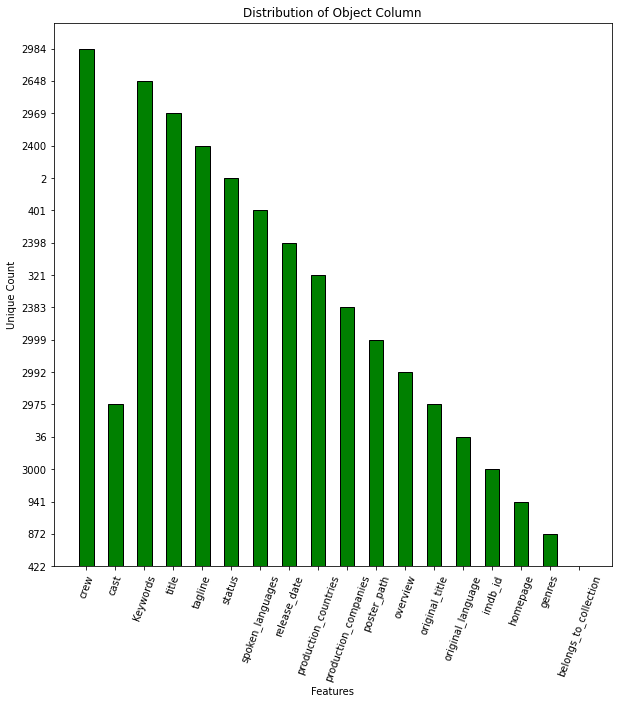

In [ ]:
# Lets see the Unique Value Distribution of Object features
Object_col = train.select_dtypes('object').columns
Analysis = []

for columns in Object_col:
    Unique = train[columns].nunique()
    Analysis.append([str(columns),Unique])

Analysis = np.array(Analysis)
plt.figure(figsize = (10,10))
plt.bar(x = Analysis[:,0],height = Analysis[:,1],width = 0.5,color = "green",edgecolor = "black")
plt.gca().invert_xaxis()
plt.xlabel("Features")
plt.ylabel("Unique Count")
plt.title("Distribution of Object Column")
plt.xticks(rotation = 70)
print("Total Size of dataset: {}".format(len(train)))

In [ ]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.270393e+07,8.463274,107.856571,6.668403e+07
std,866.169729,3.703865e+07,12.104000,22.086434,1.375139e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.402361e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,3.000000e+07,10.890983,118.000000,6.877599e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  877 non-null    object 
 2   budget                 4398 non-null   int64  
 3   genres                 4382 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4140 non-null   object 
 12  production_countries   4296 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

Total Size of dataset: 4398


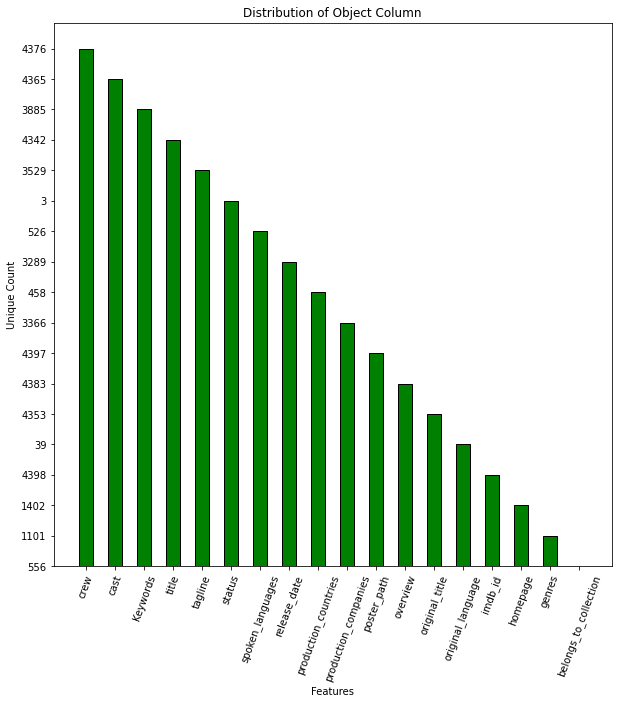

In [ ]:
# Lets see the Unique Value Distribution of Object features
Object_col = test.select_dtypes('object').columns
Analysis = []

for columns in Object_col:
    Unique = test[columns].nunique()
    Analysis.append([str(columns),Unique])

Analysis = np.array(Analysis)
plt.figure(figsize = (10,10))
plt.bar(x = Analysis[:,0],height = Analysis[:,1],width = 0.5,color = "green",edgecolor = "black")
plt.gca().invert_xaxis()
plt.xlabel("Features")
plt.ylabel("Unique Count")
plt.title("Distribution of Object Column")
plt.xticks(rotation = 70)
print("Total Size of dataset: {}".format(len(test)))

In [ ]:
test["revenue"] = np.nan

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  877 non-null    object 
 2   budget                 4398 non-null   int64  
 3   genres                 4382 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4140 non-null   object 
 12  production_countries   4296 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

In [ ]:
data = train.append(test,ignore_index=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7398 entries, 0 to 7397
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     7398 non-null   int64  
 1   belongs_to_collection  1481 non-null   object 
 2   budget                 7398 non-null   int64  
 3   genres                 7375 non-null   object 
 4   homepage               2366 non-null   object 
 5   imdb_id                7398 non-null   object 
 6   original_language      7398 non-null   object 
 7   original_title         7398 non-null   object 
 8   overview               7376 non-null   object 
 9   popularity             7398 non-null   float64
 10  poster_path            7396 non-null   object 
 11  production_companies   6984 non-null   object 
 12  production_countries   7241 non-null   object 
 13  release_date           7397 non-null   object 
 14  runtime                7392 non-null   float64
 15  spok

In [ ]:
data.describe()

,id,budget,popularity,runtime,revenue
count,7398.000000,7.398000e+03,7398.000000,7392.000000,3.000000e+03
mean,3699.500000,2.268958e+07,8.514968,107.717262,6.668403e+07
std,2135.762978,3.694930e+07,12.165794,21.480040,1.375139e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,1850.250000,0.000000e+00,3.933124,94.000000,2.402361e+06
50%,3699.500000,8.000000e+06,7.435844,104.000000,1.680707e+07
75%,5548.750000,2.900000e+07,10.920002,118.000000,6.877599e+07
max,7398.000000,3.800000e+08,547.488298,338.000000,1.519558e+09


Total Size of dataset: 7398


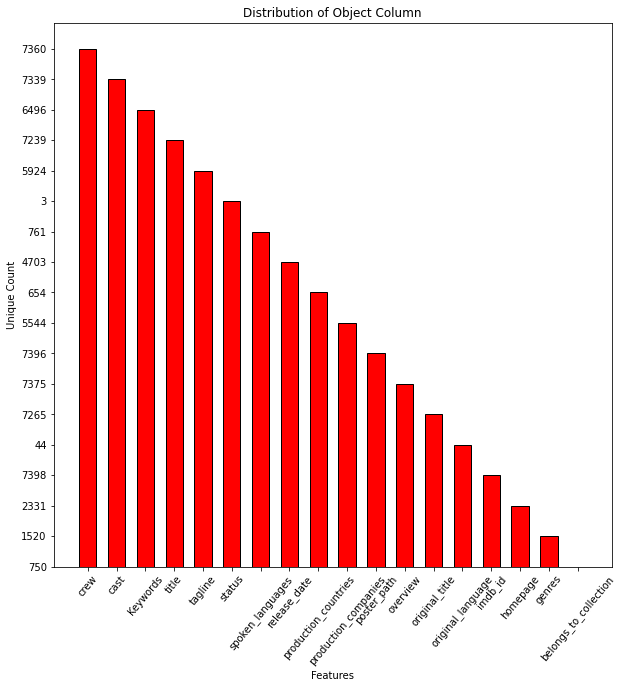

In [ ]:
# Lets see the Unique Value Distribution of Object features
Object_col = data.select_dtypes('object').columns
Analysis = []

for columns in Object_col:
    Unique = data[columns].nunique()
    Analysis.append([str(columns),Unique])

Analysis = np.array(Analysis)
plt.figure(figsize = (10,10))
plt.bar(x = Analysis[:,0],height = Analysis[:,1],width = 0.6,color = "red",edgecolor = "black")
plt.gca().invert_xaxis()
plt.xlabel("Features")
plt.ylabel("Unique Count")
plt.title("Distribution of Object Column")
plt.xticks(rotation = 50)
print("Total Size of dataset: {}".format(len(data)))

# data pre processing 

In [ ]:
columns = data.select_dtypes('object').columns
print(columns)

Index(['belongs_to_collection', 'genres', 'homepage', 'imdb_id',
       'original_language', 'original_title', 'overview', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast',
       'crew'],
      dtype='object')


In [ ]:
# print the first 10 Ids and its objects 
def display(input):
  for id,text in enumerate(data.loc[:10,input]):
    print(id,text)

##### Movie titles

In [ ]:
# print the first 10 Ids and its objects 
display('belongs_to_collection')


0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 nan
3 nan
4 nan
5 nan
6 nan
7 nan
8 [{'id': 256377, 'name': 'The Muppet Collection', 'poster_path': '/8Ew8EIdFFurMMYjSbWPu1Hl4vLX.jpg', 'backdrop_path': '/1AWd3MM90G47mxtD112gRDxSXY9.jpg'}]
9 nan
10 [{'id': 1575, 'name': 'Rocky Collection', 'poster_path': '/mCY5dMkSSFQufGCViI6jNUU6pXq.jpg', 'backdrop_path': '/w4h6gjdWPvmu5R9H6zeGDPo1ZuV.jpg'}]


In [ ]:
# Lets extract the movie names and make them as a feature 
Value = []
for instance in data.loc[:,'belongs_to_collection']:
    if isinstance(instance,str):  # Because nan in float instance and rest is string instance
        Value.append(ast.literal_eval(instance)[0]['name'])  # Extracting out the name
    else:
        Value.append(np.nan)

In [ ]:
data['belongs_to_collection'] = Value
data['belongs_to_collection'].head(5)

0    Hot Tub Time Machine Collection
1    The Princess Diaries Collection
2                                NaN
3                                NaN
4                                NaN
Name: belongs_to_collection, dtype: object

##### Genres

In [ ]:
# print the first 10 Ids and its Genres 
display('genres')

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]
5 [{'id': 16, 'name': 'Animation'}, {'id': 12, 'name': 'Adventure'}, {'id': 10751, 'name': 'Family'}]
6 [{'id': 27, 'name': 'Horror'}, {'id': 53, 'name': 'Thriller'}]
7 [{'id': 99, 'name': 'Documentary'}]
8 [{'id': 28, 'name': 'Action'}, {'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}, {'id': 10751, 'name': 'Family'}, {'id': 12, 'name': 'Adventure'}]
9 [{'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}]
10 [{'id': 18, 'name': 'Drama'}]


In [ ]:
# Lets Extract out the name first
Value = []
Count = []
for instance in data.loc[:,'genres']:
    if isinstance(instance,str):
        X = ast.literal_eval(instance)
        Count.append(len(X))   # Count Keep tracks of total Genres of One Movie
        for i in X:
            Value.append(str(i['name']))
    else:
        Count.append(0)
data['genres'] = Count

##### Homepage

In [ ]:
display('homepage')


0 nan
1 nan
2 http://sonyclassics.com/whiplash/
3 http://kahaanithefilm.com/
4 nan
5 nan
6 http://www.thepossessionmovie.com/
7 nan
8 nan
9 nan
10 nan


In [ ]:
data['homepage'].value_counts()

http://www.missionimpossible.com/                         4
http://www.transformersmovie.com/                         4
http://www.thehungergames.movie/                          4
http://www.thehobbit.com/                                 3
http://www.workandtheglory.com/                           3
                                                         ..
http://www.wbshop.com/product/code/1000040993.do          1
http://www.theofficialjohncarpenter.com/ghost-of-mars/    1
http://movies.disney.com/the-good-dinosaur                1
http://www.themenwhostareatgoatsmovie.com/                1
http://www.terminatormovie.com/                           1
Name: homepage, Length: 2331, dtype: int64

In [ ]:
data.drop(['homepage'],axis = 1,inplace = True)

##### IMDB_Id

In [ ]:
display('imdb_id')

0 tt2637294
1 tt0368933
2 tt2582802
3 tt1821480
4 tt1380152
5 tt0093743
6 tt0431021
7 tt0391024
8 tt0117110
9 tt0310281
10 tt0075148


In [ ]:
data['imdb_id'].value_counts() 

tt2637294    1
tt1046947    1
tt3395184    1
tt2425486    1
tt0099703    1
            ..
tt2649554    1
tt0303243    1
tt0387131    1
tt0848537    1
tt0056663    1
Name: imdb_id, Length: 7398, dtype: int64

In [ ]:
print(np.any(np.array(data['imdb_id'].value_counts()) == 1))

True


In [ ]:
data.drop(['imdb_id'],axis = 1,inplace = True)

##### Original Title

In [ ]:
display('original_title')

0 Hot Tub Time Machine 2
1 The Princess Diaries 2: Royal Engagement
2 Whiplash
3 Kahaani
4 마린보이
5 Pinocchio and the Emperor of the Night
6 The Possession
7 Control Room
8 Muppet Treasure Island
9 A Mighty Wind
10 Rocky


In [ ]:
data['original_title'].value_counts()

King Kong                               3
Hercules                                3
Anna Karenina                           3
Scarface                                2
The Alamo                               2
                                       ..
A Civil Action                          1
The Men Who Stare at Goats              1
Blaze                                   1
Ace Ventura: When Nature Calls          1
Vivre sa vie: film en douze tableaux    1
Name: original_title, Length: 7265, dtype: int64

In [ ]:
data.drop(['original_title'],axis = 1,inplace = True)

##### Overview

In [ ]:
display('overview')

0 When Lou, who has become the "father of the Internet," is shot by an unknown assailant, Jacob and Nick fire up the time machine again to save their friend.
1 Mia Thermopolis is now a college graduate and on her way to Genovia to take up her duties as princess. Her best friend Lilly also joins her for the summer. Mia continues her 'princess lessons'- riding horses side-saddle, archery, and other royal. But her complicated life is turned upside down once again when she not only learns that she is to take the crown as queen earlier than expected...
2 Under the direction of a ruthless instructor, a talented young drummer begins to pursue perfection at any cost, even his humanity.
3 Vidya Bagchi (Vidya Balan) arrives in Kolkata from London to find her missing husband Arnab Bagchi. Seven months pregnant and alone in a festive city, she begins a relentless search for her husband. With nothing to rely on except fragments from her memories about him, all clues seem to reach a dead end when ev

In [ ]:
data.drop(['overview'],axis = 1,inplace = True)

##### Poster Path

In [ ]:
display('poster_path')

0 /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg
1 /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg
2 /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg
3 /aTXRaPrWSinhcmCrcfJK17urp3F.jpg
4 /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg
5 /6IDqA1D2NBIVhzEEaMMRL28iBrq.jpg
6 /4QjzFuaZmB4btGnLwAgdp23BzIU.jpg
7 /83BV8fGy5p9i8RwE9oj76tZ1Ikp.jpg
8 /5A8gKzOrF9Z7tSUX6xd5dEx4NXf.jpg
9 /xwD4EsPOGLuKP50Q1gwqAsyhAFB.jpg
10 /i5xiwdSsrecBvO7mIfAJixeEDSg.jpg


In [ ]:
data['poster_path'].value_counts()      # All Unique Value We can Remove this attribute.
print(np.any(np.array(data['poster_path'].value_counts()) == 1))
data.drop(['poster_path'],axis = 1,inplace = True)

True


##### Time

In [ ]:
data['release_date'] = pd.to_datetime(data['release_date'],format="%m/%d/%y")

In [ ]:
data['release_date'].head(10)

0   2015-02-20
1   2004-08-06
2   2014-10-10
3   2012-03-09
4   2009-02-05
5   1987-08-06
6   2012-08-30
7   2004-01-15
8   1996-02-16
9   2003-04-16
Name: release_date, dtype: datetime64[ns]

##### Production Companies

In [ ]:
display('production_companies')

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 nan
4 nan
5 nan
6 [{'name': 'Ghost House Pictures', 'id': 768}, {'name': 'North Box Productions', 'id': 22637}]
7 nan
8 [{'name': 'Walt Disney Pictures', 'id': 2}, {'name': 'Jim Henson Productions', 'id': 2504}, {'name': 'Jim Henson Company, The', 'id': 6254}]
9 [{'name': 'Castle Rock Entertainment', 'id': 97}]
10 [{'name': 'United Artists', 'id': 60}]


In [ ]:
# Lets Extract out the name first
Value = []
Count = []
for instance in data.loc[:,'production_companies']:
    if isinstance(instance,str):
        X = ast.literal_eval(instance)
        Count.append(len(X))   # Count Keep tracks of total Production Companirs of One Movie
        for i in X:
            Value.append(str(i['name']))
    else:
        Count.append(0)

In [ ]:
pd.DataFrame(Value).value_counts().index[:5] # We have to work on it and bring in right format

MultiIndex([(                          'Warner Bros.',),
            (                    'Universal Pictures',),
            (                    'Paramount Pictures',),
            ('Twentieth Century Fox Film Corporation',),
            (                     'Columbia Pictures',)],
           )

In [ ]:
Correct_index = []
for index in pd.DataFrame(Value).value_counts().index:
    Correct_index.append(index[0])
print(Correct_index[:5])

['Warner Bros.', 'Universal Pictures', 'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Columbia Pictures']


In [ ]:
data['production_companies'] = Count

##### Production Countries

In [ ]:
display('production_countries')

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
5 nan
6 [{'iso_3166_1': 'US', 'name': 'United States of America'}, {'iso_3166_1': 'CA', 'name': 'Canada'}]
7 nan
8 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
9 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
10 [{'iso_3166_1': 'US', 'name': 'United States of America'}]


In [ ]:
# Same treatment we can give it as above
# Lets Extract out the name first
Value = []
Count = []
for instance in data.loc[:,'production_countries']:
    if isinstance(instance,str):
        X = ast.literal_eval(instance)
        Count.append(len(X))   # Count Keep tracks of total Production Countries of One Movie
        for i in X:
            Value.append(str(i['name']))
    else:
        Count.append(0)

In [ ]:
Value = pd.DataFrame(Value).rename(columns = {0:"Name"})
df = Value.value_counts()

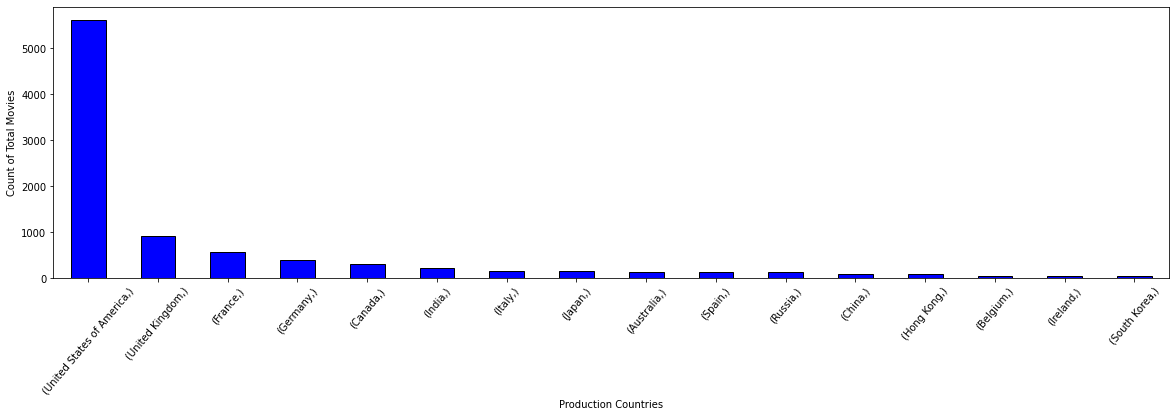

In [ ]:
df.loc[df > 50].plot(kind = "bar",color = "blue",edgecolor = "black",figsize = (20,5)) 
plt.xticks(rotation = 50)
plt.xlabel("Production Countries")
plt.ylabel("Count of Total Movies")
plt.show()
data['production_countries'] = Count
# Plotting the the Countries who created more than 50 movie

##### Spoken Languages

In [ ]:
display('spoken_languages')

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
5 [{'iso_639_1': 'en', 'name': 'English'}]
6 [{'iso_639_1': 'en', 'name': 'English'}]
7 [{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso_639_1': 'en', 'name': 'English'}]
8 [{'iso_639_1': 'en', 'name': 'English'}]
9 [{'iso_639_1': 'en', 'name': 'English'}]
10 [{'iso_639_1': 'en', 'name': 'English'}]


In [ ]:
# We can Do same treatment as Earlier
# Lets Extract out the name first
Value = []
Count = []
for instance in data.loc[:,'spoken_languages']:
    if isinstance(instance,str):
        X = ast.literal_eval(instance)
        Count.append(len(X))   # Count Keep tracks of total Languages of One Movie
        for i in X:
            Value.append(str(i['name']))
    else:
        Count.append(0)

In [ ]:
Value[:10]

['English',
 'English',
 'English',
 'English',
 'हिन्दी',
 '한국어/조선말',
 'English',
 'English',
 'العربية',
 'English']

In [ ]:
Correct_index = []
for index in pd.DataFrame(Value).value_counts().index:
    Correct_index.append(index[0])
print(Correct_index[:5])

['English', 'Français', 'Español', 'Deutsch', 'Pусский']


In [ ]:
data['spoken_languages'] = Count

##### Tagline

In [ ]:
display('tagline')

0 The Laws of Space and Time are About to be Violated.
1 It can take a lifetime to find true love; she's got 30 days!
2 The road to greatness can take you to the edge.
3 nan
4 nan
5 nan
6 Fear The Demon That Doesn't Fear God
7 Different channels. Different truths.
8 Set sail for Muppet mayhem!
9 Back together for the first time, again.
10 His whole life was a million-to-one shot.


In [ ]:
data.drop(['tagline'],inplace = True,axis = 1)

##### Title

In [ ]:
display('title')

0 Hot Tub Time Machine 2
1 The Princess Diaries 2: Royal Engagement
2 Whiplash
3 Kahaani
4 Marine Boy
5 Pinocchio and the Emperor of the Night
6 The Possession
7 Control Room
8 Muppet Treasure Island
9 A Mighty Wind
10 Rocky


In [ ]:
data['title'].value_counts() 

Anna Karenina                 3
Ghost                         3
Beauty and the Beast          3
Hercules                      3
King Kong                     3
                             ..
Elektra                       1
The Next Three Days           1
A Civil Action                1
The Men Who Stare at Goats    1
Vivre Sa Vie                  1
Name: title, Length: 7239, dtype: int64

In [ ]:
data.drop(['title'],inplace = True,axis = 1)

##### Keywords

In [ ]:
display('Keywords')

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [ ]:
# We can Do same treatment as Earlier

Count = []
for instance in data.loc[:,'Keywords']:
    if isinstance(instance,str):
        X = ast.literal_eval(instance)
        Count.append(len(X))   # Count Keep tracks of total Keywords of One Movie
    else:
        Count.append(0)

In [ ]:
data['Keywords'] = Count

##### cast

In [ ]:
display('cast')

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [ ]:
# We can Do same treatment as Earlier

Count = []
for instance in data.loc[:,'cast']:
    if isinstance(instance,str):
        X = ast.literal_eval(instance)
        Count.append(len(X))   # Count Keep tracks of total casts of One Movie
    else:
        Count.append(0)

In [ ]:
data['cast'] = Count

crew

In [ ]:
display('crew')

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In [ ]:
# We can Do same treatment as Earlier

Count = []
for instance in data.loc[:,'crew']:
    if isinstance(instance,str):
        X = ast.literal_eval(instance)
        Count.append(len(X))   # Count Keep tracks of total crew of One Movie
    else:
        Count.append(0)

In [ ]:
data['crew'] = Count

In [ ]:
data.describe()

,id,budget,genres,popularity,production_companies,production_countries,runtime,spoken_languages,Keywords,cast,crew,revenue
count,7398.000000,7.398000e+03,7398.000000,7398.000000,7398.000000,7398.000000,7392.000000,7398.000000,7398.000000,7398.000000,7398.000000,3.000000e+03
mean,3699.500000,2.268958e+07,2.495539,8.514968,2.744526,1.332793,107.717262,1.446067,7.243039,20.956204,24.275480,6.668403e+07
std,2135.762978,3.694930e+07,1.119068,12.165794,2.186800,0.790359,21.480040,0.894305,6.254883,17.446726,28.139666,1.375139e+08
min,1.000000,0.000000e+00,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00
25%,1850.250000,0.000000e+00,2.000000,3.933124,1.000000,1.000000,94.000000,1.000000,3.000000,11.000000,8.000000,2.402361e+06
50%,3699.500000,8.000000e+06,2.000000,7.435844,2.000000,1.000000,104.000000,1.000000,6.000000,16.000000,14.000000,1.680707e+07
75%,5548.750000,2.900000e+07,3.000000,10.920002,4.000000,1.000000,118.000000,2.000000,10.000000,24.000000,28.000000,6.877599e+07
max,7398.000000,3.800000e+08,8.000000,547.488298,26.000000,12.000000,338.000000,9.000000,149.000000,165.000000,194.000000,1.519558e+09


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7398 entries, 0 to 7397
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     7398 non-null   int64         
 1   belongs_to_collection  1481 non-null   object        
 2   budget                 7398 non-null   int64         
 3   genres                 7398 non-null   int64         
 4   original_language      7398 non-null   object        
 5   popularity             7398 non-null   float64       
 6   production_companies   7398 non-null   int64         
 7   production_countries   7398 non-null   int64         
 8   release_date           7397 non-null   datetime64[ns]
 9   runtime                7392 non-null   float64       
 10  spoken_languages       7398 non-null   int64         
 11  status                 7396 non-null   object        
 12  Keywords               7398 non-null   int64         
 13  cas

In [ ]:
data.head(1)

,id,belongs_to_collection,budget,genres,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,Keywords,cast,crew,revenue
0,1,Hot Tub Time Machine Collection,14000000,1,en,6.575393,3,1,2015-02-20,93.0,1,Released,4,24,72,12314651.0


In [ ]:
# Lets see Null values Now.
Null_Values = pd.DataFrame(data.isnull().sum()).rename(columns = {0:'Total'})
Null_Values['Percent'] = Null_Values['Total']/len(data)
Null_Values.sort_values('Percent',ascending=False).head()

,Total,Percent
belongs_to_collection,5917,0.799811
revenue,4398,0.594485
runtime,6,0.000811
status,2,0.000270
release_date,1,0.000135


In [ ]:
# Lets Manually first store the index where Null values are present becasue Label Encoding will also encode Null values
index = list(Null_Values[Null_Values['Total'] >= 1].index)
index.remove('revenue')
Position = []
for col in index:
    temp = data[data[col].isnull()].index
    Position.append([col,temp])  

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Lets Apply Label Encoding to object Columns
Object_Columns = data.select_dtypes('object').columns
data[Object_Columns] = data.select_dtypes('object').apply(LabelEncoder().fit_transform)

In [ ]:
data.head(1)

,id,belongs_to_collection,budget,genres,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,Keywords,cast,crew,revenue
0,1,281,14000000,1,10,6.575393,3,1,2015-02-20,93.0,1,1,4,24,72,12314651.0


In [ ]:
for instance in Position:
    data.loc[instance[1],instance[0]] = np.nan

In [ ]:
data.head(1)

,id,belongs_to_collection,budget,genres,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,Keywords,cast,crew,revenue
0,1,281.0,14000000,1,10,6.575393,3,1,2015-02-20,93.0,1,1.0,4,24,72,12314651.0


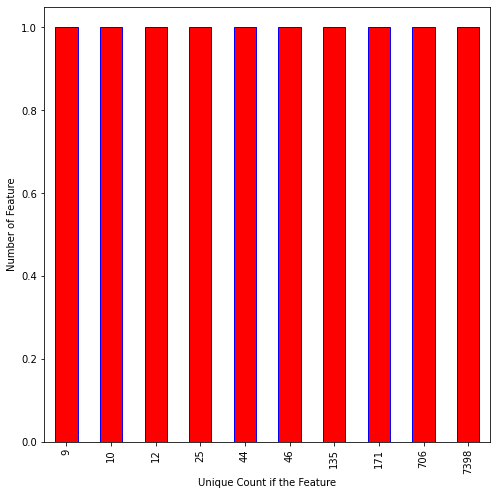

In [ ]:
# Lets see how many Unique Values are there in Integer columns
Integer_Columns = [col for col in data if 'int' in str(data[col].dtypes)]
data[Integer_Columns].nunique().value_counts().sort_index().plot(kind = 'bar',figsize = (8,8),edgecolor = 'blue',color = 'red')
plt.xlabel('Unique Count if the Feature')
plt.ylabel('Number of Feature')
plt.show()

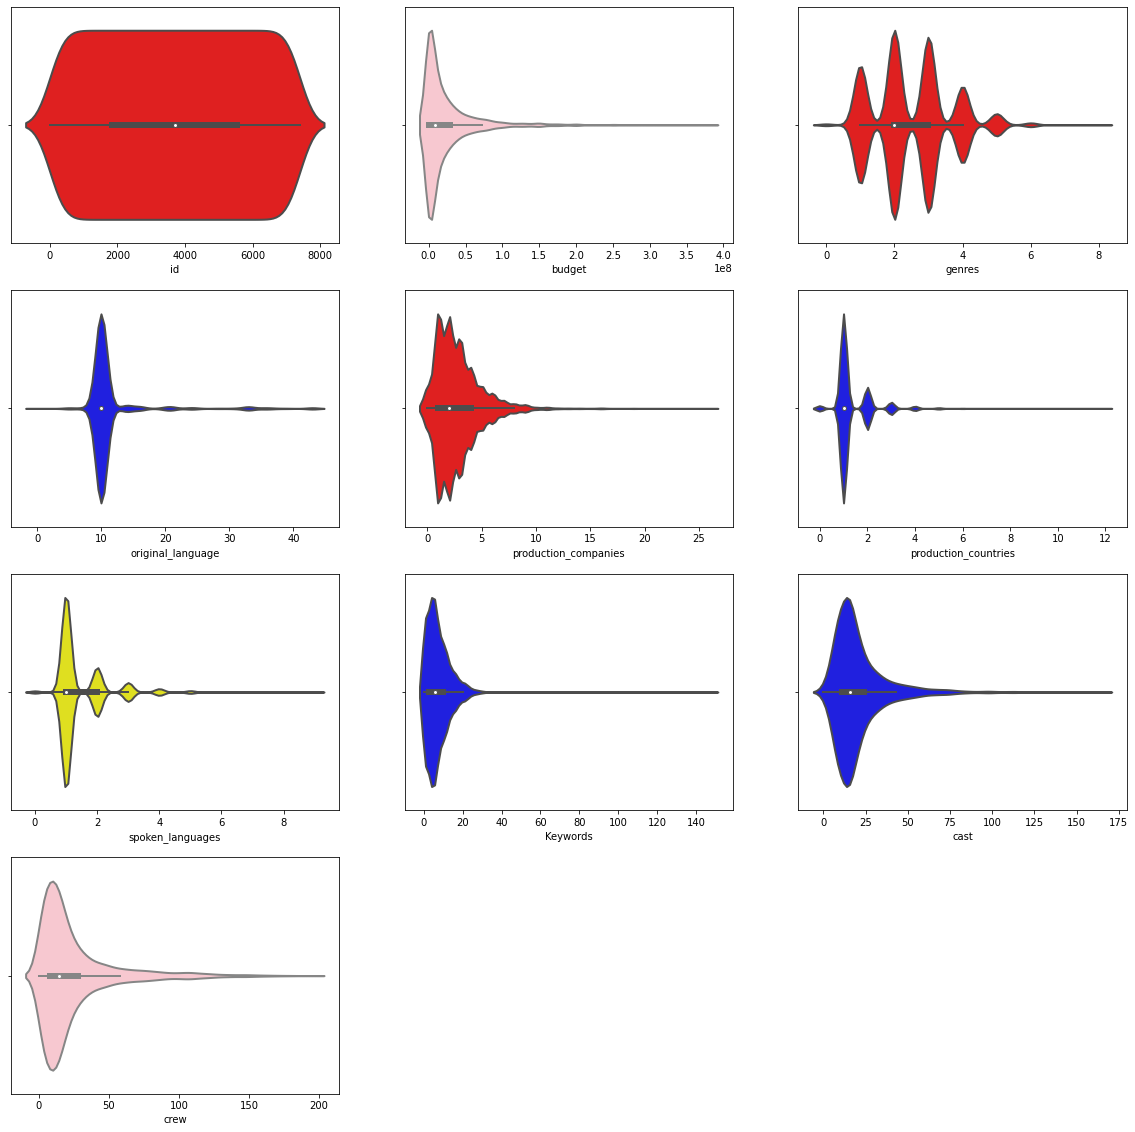

In [ ]:
import warnings
warnings.filterwarnings('ignore',category = FutureWarning)

# Lets See the Distribution of Each of them
import seaborn as sns
plt.figure(figsize=(20,20))
color = ['red','green','blue','orange','pink','yellow']
for idx,col in enumerate(Integer_Columns):
    ax = plt.subplot(4,3,idx+1)
    color_idx = np.random.randint(0,len(color))
    sns.violinplot(data[col],ax=ax,color=color[color_idx],linewidth=2)


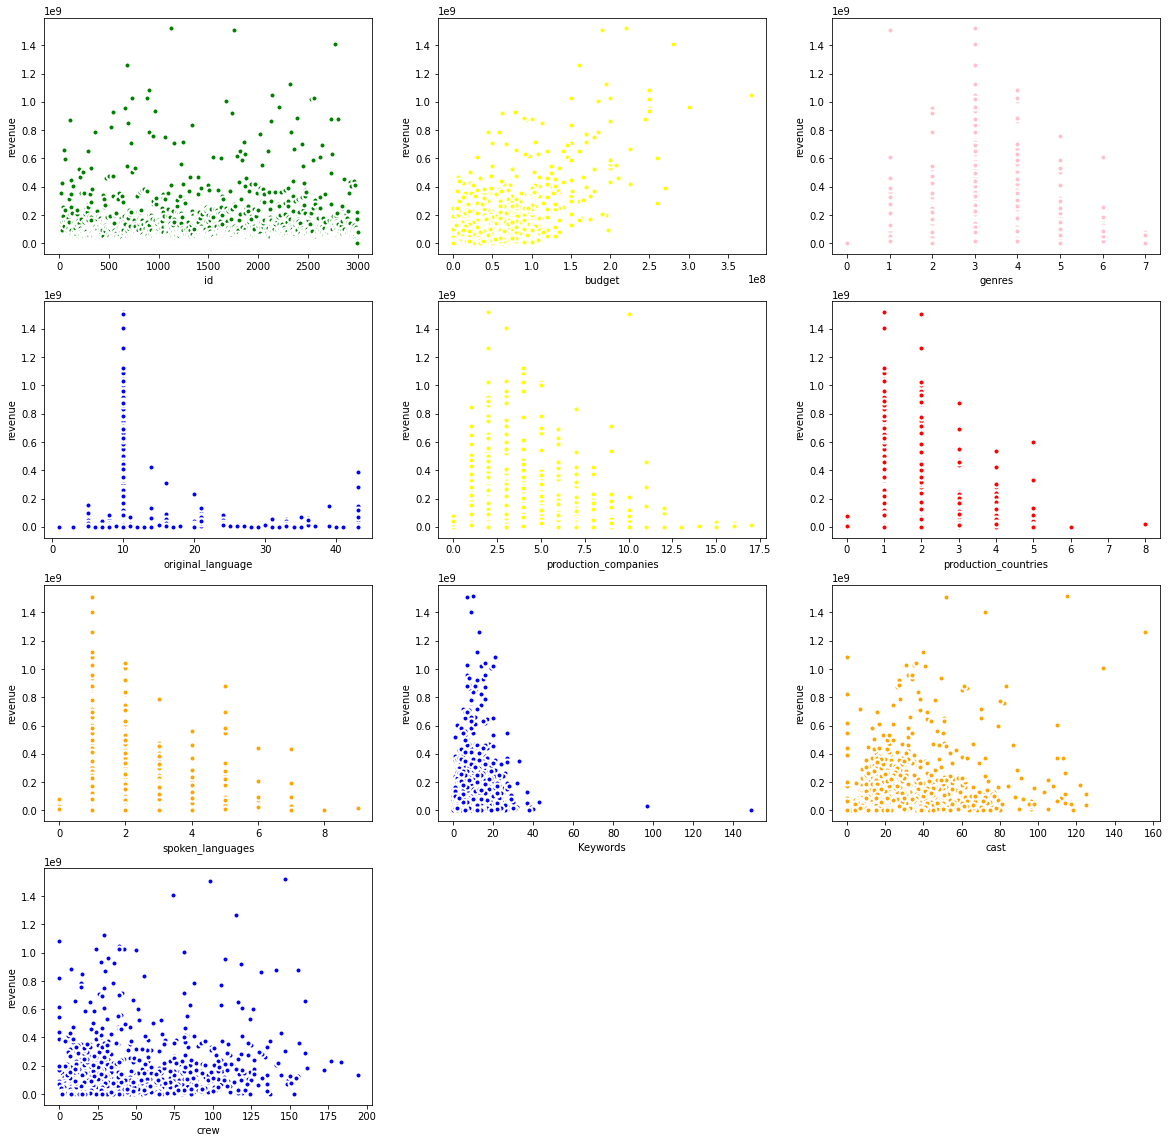

In [ ]:
# Lets see how they are related to our target Variable
import warnings
warnings.filterwarnings('ignore',category = FutureWarning)

# Lets See the Distribution of Each of them
import seaborn as sns
plt.figure(figsize=(20,20))
color = ['red','green','blue','orange','pink','yellow']
for idx,col in enumerate(Integer_Columns):
    ax = plt.subplot(4,3,idx+1)
    color_idx = np.random.randint(0,len(color))
    sns.scatterplot(data[col],data['revenue'],ax=ax,color=color[color_idx],linewidth=2)

    
# No Clear Correlation are Visible. Budget and revenue seems to be correlated

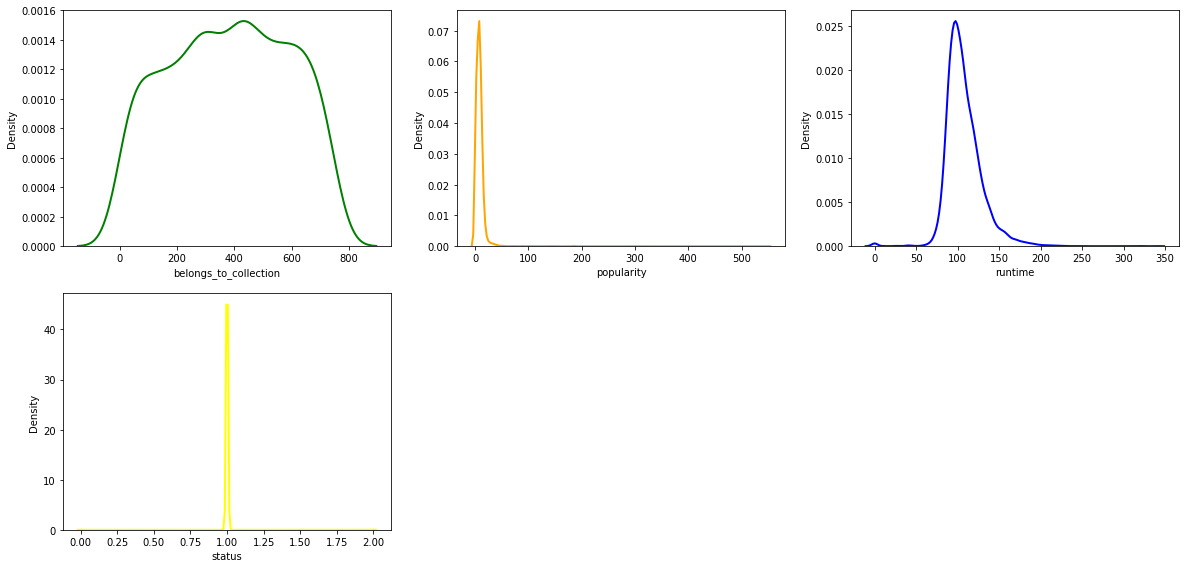

In [ ]:
import warnings
warnings.filterwarnings('ignore',category = FutureWarning)

Float_columns = [col for col in data if 'float' in str(data[col].dtypes)]
Float_columns.remove('revenue')
# Lets See the Distribution of Float columns Each of them
import seaborn as sns
plt.figure(figsize=(20,20))
color = ['red','green','blue','orange','pink','yellow']
for idx,col in enumerate(Float_columns):
    ax = plt.subplot(4,3,idx+1)
    color_idx = np.random.randint(0,len(color))
    Mean,Median = np.mean(data[col]),np.median(data[col])
    sns.kdeplot(data[col],ax=ax,color=color[color_idx],linewidth=2)

    
# Some of them are Skewed. Some of them are almost gaussian centered at their respective mean

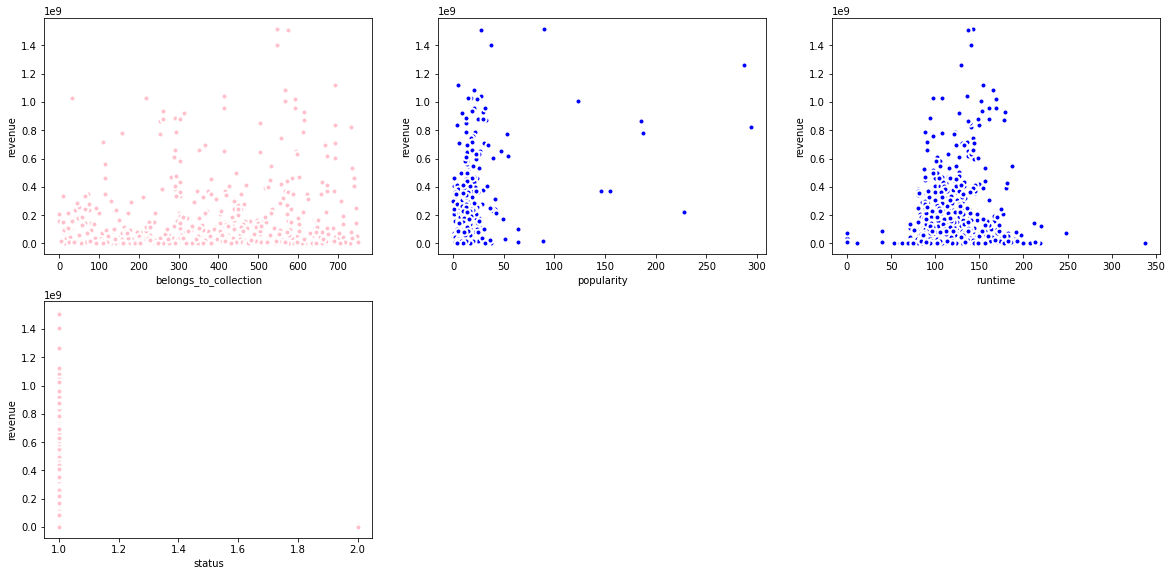

In [ ]:
# Lets see how they are related to our target Variable
import warnings
warnings.filterwarnings('ignore',category = FutureWarning)

# Lets See the Distribution of Each of them
import seaborn as sns
plt.figure(figsize=(20,20))
color = ['red','green','blue','orange','pink','yellow']
for idx,col in enumerate(Float_columns):
    ax = plt.subplot(4,3,idx+1)
    color_idx = np.random.randint(0,len(color))
    sns.scatterplot(data[col],data['revenue'],ax=ax,color=color[color_idx],linewidth=2)

    
# No Clear Correlation are Visible. Budget and revenue seems to be correlated

In [ ]:
# Lets see Null values Again.
Null_Values = pd.DataFrame(data.isnull().sum()).rename(columns = {0:'Total'})
Null_Values['Percent'] = Null_Values['Total']/len(data)
Null_Values.sort_values('Percent',ascending=False).head(10)

,Total,Percent
belongs_to_collection,5917,0.799811
revenue,4398,0.594485
runtime,6,0.000811
status,2,0.000270
release_date,1,0.000135
id,0,0.000000
budget,0,0.000000
genres,0,0.000000
original_language,0,0.000000
popularity,0,0.000000


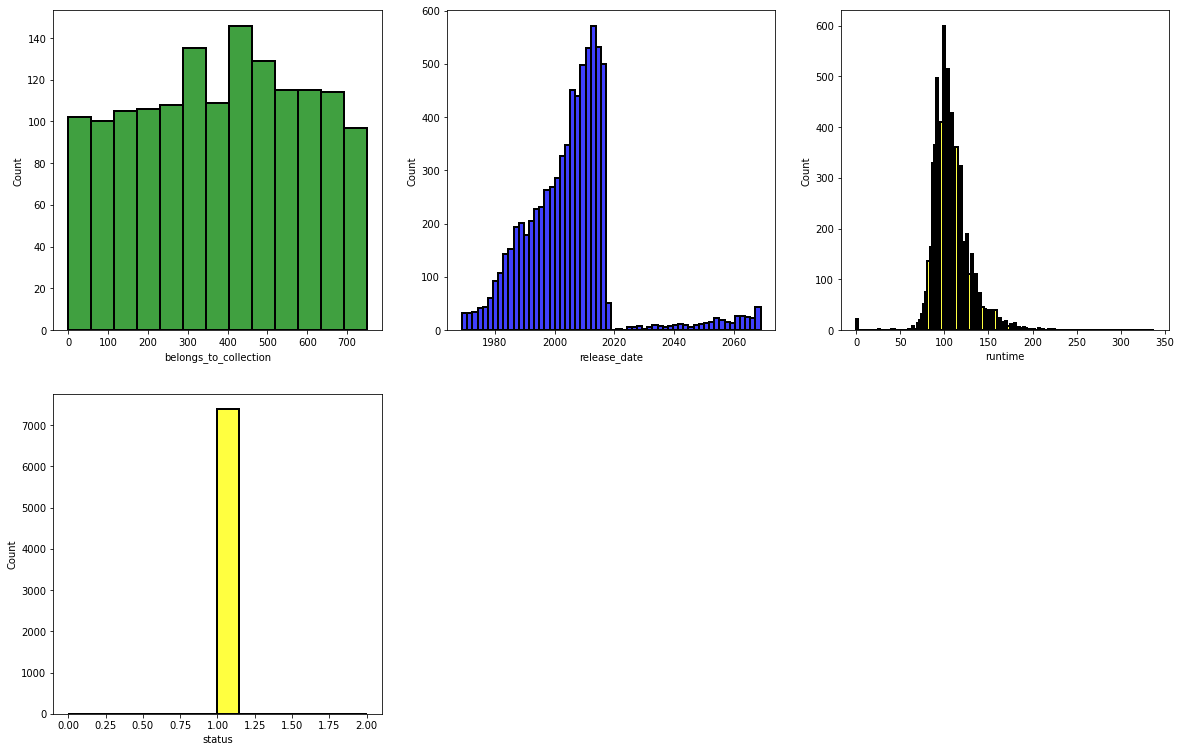

In [ ]:
# Lets see what values we should Put in these
Null_Columns = list(Null_Values[Null_Values['Total'] >= 1].index)
Null_Columns.remove('revenue')
import warnings
warnings.filterwarnings('ignore',category = FutureWarning)

# Lets See the Distribution of Each of them
import seaborn as sns
plt.figure(figsize=(20,20))
color = ['red','green','blue','orange','pink','yellow']
for idx,col in enumerate(Null_Columns):
    ax = plt.subplot(3,3,idx+1)
    color_idx = np.random.randint(0,len(color))
    sns.histplot(data[col],ax=ax,color=color[color_idx],linewidth=2)

# Lets fill them with the median Value 

In [ ]:
data.head(5)

,id,belongs_to_collection,budget,genres,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,Keywords,cast,crew,revenue
0,1,281.0,14000000,1,10,6.575393,3,1,2015-02-20,93.0,1,1.0,4,24,72,12314651.0
1,2,640.0,40000000,4,10,8.248895,1,1,2004-08-06,113.0,1,1.0,4,20,9,95149435.0
2,3,NaN,3300000,1,10,64.299990,3,1,2014-10-10,105.0,1,1.0,12,51,64,13092000.0
3,4,NaN,1200000,2,16,3.174936,0,1,2012-03-09,122.0,2,1.0,7,7,3,16000000.0
4,5,NaN,0,2,24,1.148070,0,1,2009-02-05,118.0,1,1.0,0,4,2,3923970.0


In [ ]:
# Lets Start Feature Engineering
# Lets first remove any redundant feature having correlation greater than 95%
Correlation_Matrix = data.corr()
Triu = Correlation_Matrix.where(np.triu(np.ones(Correlation_Matrix.shape),k = 1).astype(np.bool))  # Will return Upper triangle
Redundant_col = [col for col in Triu if np.any(Triu[col].abs() >= 0.95)]

In [ ]:
data.drop(Redundant_col,axis = 1,inplace = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7398 entries, 0 to 7397
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     7398 non-null   int64         
 1   belongs_to_collection  1481 non-null   float64       
 2   budget                 7398 non-null   int64         
 3   genres                 7398 non-null   int64         
 4   original_language      7398 non-null   int64         
 5   popularity             7398 non-null   float64       
 6   production_companies   7398 non-null   int64         
 7   production_countries   7398 non-null   int64         
 8   release_date           7397 non-null   datetime64[ns]
 9   runtime                7392 non-null   float64       
 10  spoken_languages       7398 non-null   int64         
 11  status                 7396 non-null   float64       
 12  Keywords               7398 non-null   int64         
 13  cas

In [ ]:
data.head(1)

,id,belongs_to_collection,budget,genres,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,Keywords,cast,crew,revenue
0,1,281.0,14000000,1,10,6.575393,3,1,2015-02-20,93.0,1,1.0,4,24,72,12314651.0


# Featuere_tools

In [ ]:
from sklearn.preprocessing import StandardScaler
OriginalLabel = data.loc[data['revenue'].notnull(),'revenue']
Columns = data.columns

In [ ]:
# Lets Manually Create Some Features
import featuretools as ft
es = ft.EntitySet(id = 'TMDB')
es = es.add_dataframe(dataframe_name="data_tmdb",dataframe=data,make_index=True,index = 'TMDB_id')

In [ ]:
es

Entityset: TMDB
  DataFrames:
    data_tmdb [Rows: 7398, Columns: 17]
  Relationships:
    No relationships

In [ ]:
es['data_tmdb']

,TMDB_id,id,belongs_to_collection,budget,genres,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,Keywords,cast,crew,revenue
0,0,1,281.0,14000000,1,10,6.575393,3,1,2015-02-20,93.0,1,1.0,4,24,72,12314651.0
1,1,2,640.0,40000000,4,10,8.248895,1,1,2004-08-06,113.0,1,1.0,4,20,9,95149435.0
2,2,3,NaN,3300000,1,10,64.299990,3,1,2014-10-10,105.0,1,1.0,12,51,64,13092000.0
3,3,4,NaN,1200000,2,16,3.174936,0,1,2012-03-09,122.0,2,1.0,7,7,3,16000000.0
4,4,5,NaN,0,2,24,1.148070,0,1,2009-02-05,118.0,1,1.0,0,4,2,3923970.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7393,7393,7394,NaN,42000000,1,10,9.970359,7,2,2001-08-03,118.0,5,1.0,9,10,11,NaN
7394,7394,7395,730.0,19000000,4,10,6.046516,2,1,2004-08-20,95.0,1,1.0,2,22,94,NaN
7395,7395,7396,NaN,16000000,1,10,9.596883,1,1,1982-12-08,129.0,1,1.0,6,17,12,NaN
7396,7396,7397,NaN,2000000,2,10,20.359336,3,1,2015-02-04,100.0,1,1.0,7,29,29,NaN


In [ ]:
feature_matrix,feature_dfs = ft.dfs(entityset=es, target_dataframe_name="data_tmdb",trans_primitives=["add_numeric","cum_mean","cum_sum","percentile"],max_depth=2)

In [ ]:
feature_matrix.shape

(7398, 165)

In [ ]:
Label = feature_matrix["revenue"]
Remove_col = []
for col in feature_matrix:
    if "revenue" in str(col):
        Remove_col.append(col)
Remove_col[:5]

['revenue',
 'Keywords + revenue',
 'belongs_to_collection + revenue',
 'budget + revenue',
 'cast + revenue']

In [ ]:
feature_matrix.drop(Remove_col,axis = 1,inplace = True)

In [ ]:
feature_matrix.head()

,id,belongs_to_collection,budget,genres,original_language,popularity,production_companies,production_countries,runtime,spoken_languages,...,PERCENTILE(crew),PERCENTILE(genres),PERCENTILE(id),PERCENTILE(original_language),PERCENTILE(popularity),PERCENTILE(production_companies),PERCENTILE(production_countries),PERCENTILE(runtime),PERCENTILE(spoken_languages),PERCENTILE(status)
TMDB_id,,,,,,,,,,,,,,,,,,,,,
0,1,281.0,14000000,1,10,6.575393,3,1,93.0,1,...,0.923898,0.103744,0.000135,0.445661,0.428494,0.647743,0.390579,0.221050,0.361652,0.5
1,2,640.0,40000000,4,10,8.248895,1,1,113.0,1,...,0.302582,0.889700,0.000270,0.445661,0.568667,0.184780,0.390579,0.678098,0.361652,0.5
2,3,NaN,3300000,1,10,64.299990,3,1,105.0,1,...,0.907475,0.103744,0.000406,0.445661,0.996756,0.647743,0.390579,0.523742,0.361652,0.5
3,4,NaN,1200000,2,16,3.174936,0,1,122.0,2,...,0.104690,0.365099,0.000541,0.924642,0.212625,0.028048,0.390579,0.805330,0.804001,0.5
4,5,NaN,0,2,24,1.148070,0,1,118.0,1,...,0.055218,0.365099,0.000676,0.957015,0.091646,0.028048,0.390579,0.752773,0.361652,0.5


In [ ]:
Correlation_Matrix = feature_matrix.corr()
Triu = Correlation_Matrix.where(np.triu(np.ones(Correlation_Matrix.shape),k = 1).astype(np.bool))  # Will return Upper triangle
Redundant_col = [col for col in Triu if np.any(Triu[col].abs() >= 0.95)]

In [ ]:
feature_matrix.drop(Redundant_col,axis = 1,inplace = True)

In [ ]:
feature_matrix.head()

,id,belongs_to_collection,budget,genres,original_language,popularity,production_companies,production_countries,runtime,spoken_languages,...,PERCENTILE(Keywords),PERCENTILE(budget),PERCENTILE(cast),PERCENTILE(crew),PERCENTILE(original_language),PERCENTILE(popularity),PERCENTILE(production_companies),PERCENTILE(production_countries),PERCENTILE(runtime),PERCENTILE(spoken_languages)
TMDB_id,,,,,,,,,,,,,,,,,,,,,
0,1,281.0,14000000,1,10,6.575393,3,1,93.0,1,...,0.334888,0.595228,0.744931,0.923898,0.445661,0.428494,0.647743,0.390579,0.221050,0.361652
1,2,640.0,40000000,4,10,8.248895,1,1,113.0,1,...,0.334888,0.820695,0.649703,0.302582,0.445661,0.568667,0.184780,0.390579,0.678098,0.361652
2,3,NaN,3300000,1,10,64.299990,3,1,105.0,1,...,0.819951,0.398418,0.939308,0.907475,0.445661,0.996756,0.647743,0.390579,0.523742,0.361652
3,4,NaN,1200000,2,16,3.174936,0,1,122.0,2,...,0.585699,0.334685,0.097662,0.104690,0.924642,0.212625,0.028048,0.390579,0.805330,0.804001
4,5,NaN,0,2,24,1.148070,0,1,118.0,1,...,0.045283,0.135104,0.029738,0.055218,0.957015,0.091646,0.028048,0.390579,0.752773,0.361652


In [ ]:
feature_matrix['revenue'] = Label
del Label

In [ ]:
Train = feature_matrix.loc[feature_matrix['revenue'].notnull(),:]
Test = feature_matrix.loc[feature_matrix['revenue'].isnull(),:]

In [ ]:
Label = OriginalLabel
Train.drop(['revenue'],inplace = True,axis = 1)
Test.drop(['revenue'],inplace = True,axis = 1)

In [ ]:
Features = Train.columns

In [ ]:
len(Features)

52

In [ ]:
Label = Label.values

In [ ]:
len(Label)

3000

# Random Forest Regressor

In [ ]:
# Lets start Machine Learning From Here
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score,make_scorer
#Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).
#A constant model that always predicts the expected value of y, disregarding the input features,
#would get a R^2 score of 0.0.

imputer = SimpleImputer(strategy="median")
score_fn = make_scorer(r2_score,greater_is_better=True)

In [ ]:
Train = imputer.fit_transform(Train)
Test = imputer.transform(Test)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.ensemble import RandomForestRegressor   # Our Base Model 
from sklearn.model_selection import cross_val_score

RandomForest = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42)
cv_score = cross_val_score(RandomForest,Train,Label,cv = 10,scoring=score_fn)

In [ ]:
print("10 Fold Cross Validation Mean R2_SCORE: {0} with Deviation: {1}".format(round(np.mean(cv_score),3),round(cv_score.std(),3)))

10 Fold Cross Validation Mean R2_SCORE: 0.638 with Deviation: 0.096


In [ ]:
RandomForest.fit(Train,Label)
feature_importance = pd.DataFrame({'Features':Features,'Importance':RandomForest.feature_importances_})

In [ ]:
def Plot_Importance(df,count = 5,threshold = 0.95):
    df['Importance'] = df['Importance']/df['Importance'].sum()
    df = df.sort_values('Importance',ascending = False).reset_index(drop = True)
    
    df['cum_sum'] = np.cumsum(df['Importance'])
    
    # Plotting Values
    df.loc[:count,:].plot(kind = 'barh',x = 'Features',y = 'Importance',color = 'green',
                          edgecolor = 'blue',figsize = (5,5),linewidth = 2)
    plt.xlabel("Normalized Importance")
    plt.xscale("log")
    plt.gca().invert_yaxis()
    
    plt.show()
    
    if threshold:
        min_ = np.min(np.where(df['cum_sum'] > threshold))
        plt.xlabel('# Features', size = 10)
        plt.ylabel('Cumulative Importance', size = 10)
        plt.title('Cumulative Importance of Features', size = 10)
        plt.plot(np.arange(len(df)),df['cum_sum'],color = 'red')
        plt.vlines(min_ + 1,ymin = 0,ymax = 1,color = 'black',linestyles='dotted')
        plt.show()
        print('Number of Columns required for {0} threshold is: {1}'.format(threshold,min_+1))
    return df

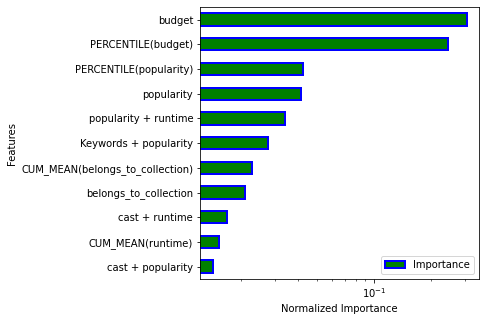

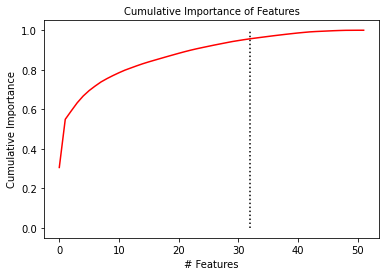

Number of Columns required for 0.95 threshold is: 32


In [ ]:
feature_importance = Plot_Importance(feature_importance,count=10)

# XGBoost

In [ ]:
# Reading the downloaded content and turning it into a pandas dataframe
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

In [ ]:
## From this function, you can convert release_date column from the character data type to the datetime data type

def date_features(df):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_day'] = df['release_date'].dt.day
    df['release_quarter'] = df['release_date'].dt.quarter
    df.drop(columns=['release_date'], inplace=True)
    return df

train=date_features(train)
test=date_features(test)

train['release_year'].head(10)

0    2015
1    2004
2    2014
3    2012
4    2009
5    1987
6    2012
7    2004
8    1996
9    2003
Name: release_year, dtype: int64

In [ ]:
train['release_year'].iloc[np.where(train['release_year']> 2022)][:10]

39     2065
41     2067
51     2065
61     2056
68     2062
109    2066
140    2068
144    2067
172    2066
187    2028
Name: release_year, dtype: int64

In [ ]:
train['release_year']=np.where(train['release_year']> 2019, train['release_year']-100, train['release_year'])
test['release_year']=np.where(test['release_year']> 2019, test['release_year']-100, test['release_year'])

In [ ]:
## Filling NA values with mode of each column

fillna_column = {'release_year':'mode','release_month':'mode',
                'release_day':'mode'}

for k,v in fillna_column.items():
    if v == 'mode':
        fill = train[k].mode()[0]
    else:
        fill = v
    print(k, ': ', fill)
    train[k].fillna(value = fill, inplace = True)
    test[k].fillna(value = fill, inplace = True)

release_year :  2013
release_month :  9
release_day :  1


In [ ]:
# Putting revised year, month, and day together 

def year_month_together(df):
    year = df["release_year"].astype(int).copy().astype(str)
    month=df['release_month'].astype(int).copy().astype(str)
    day=df['release_day'].astype(int).copy().astype(str) 
    df["release_date"]=  month.str.cat(day.str.cat(year,sep="/"), sep ="/") 
    df['release_date']=pd.to_datetime(df['release_date'],format="%m/%d/%Y")
    df['release_dow'] = df['release_date'].dt.dayofweek
    return df 

train=year_month_together(train)
test=year_month_together(test)

train['release_date'].head(10)

0   2015-02-20
1   2004-08-06
2   2014-10-10
3   2012-03-09
4   2009-02-05
5   1987-08-06
6   2012-08-30
7   2004-01-15
8   1996-02-16
9   2003-04-16
Name: release_date, dtype: datetime64[ns]

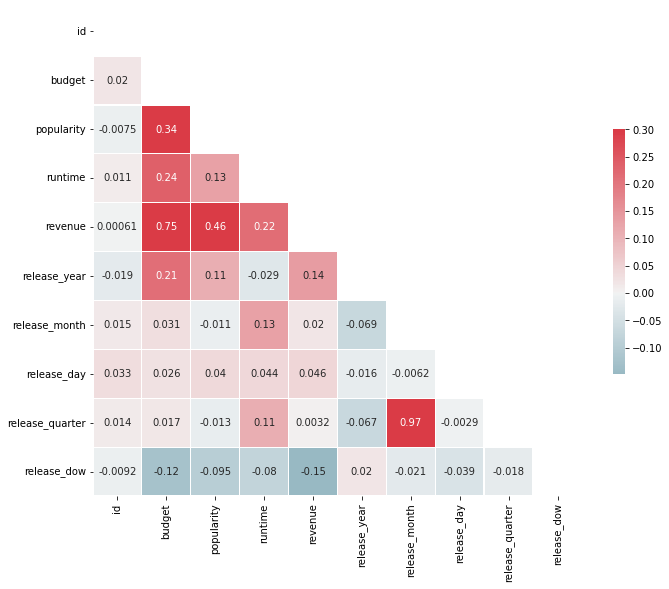

In [ ]:
# Creating correlation matrix 

corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [ ]:
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

## **Belong_to collection**

In [ ]:
# Counting NAs as 0
train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [ ]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['has_collection'] = test['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)

train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

In [ ]:
# Most common collection 
train['collection_name'].value_counts()[1:10]

James Bond Collection                     16
Friday the 13th Collection                 7
The Pink Panther (Original) Collection     6
Police Academy Collection                  5
Pokémon Collection                         5
Paranormal Activity Collection             4
Transformers Collection                    4
Rocky Collection                           4
Resident Evil Collection                   4
Name: collection_name, dtype: int64

## **Genres**

In [ ]:
from collections import Counter

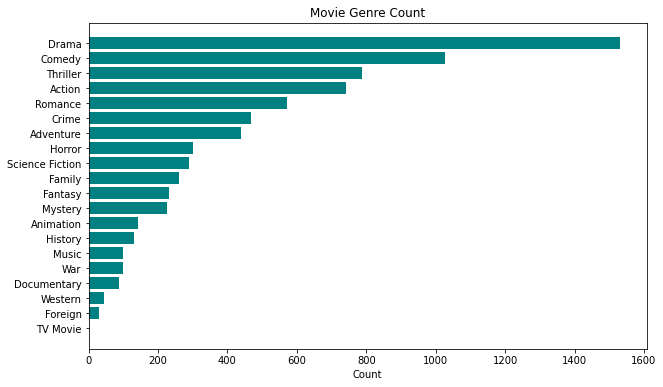

In [ ]:
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
most_common_genres=Counter([i for j in list_of_genres for i in j]).most_common()
fig = plt.figure(figsize=(10, 6))
data=dict(most_common_genres)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='teal')
plt.xlabel('Count')
plt.title('Movie Genre Count')
plt.show()

In [ ]:
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)

In [ ]:
import nltk
nltk.download("stopwords") 
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


There are 48476 words in the combination of all review.


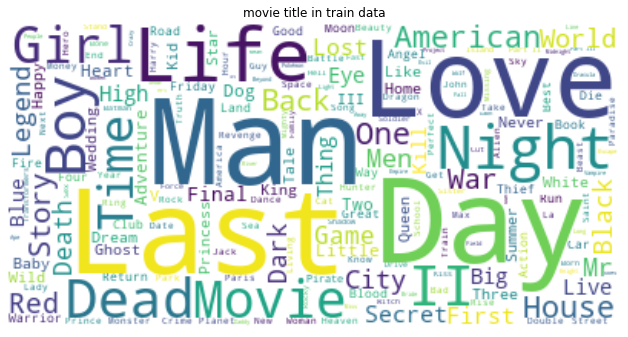

In [ ]:
# Movie title text analysis 

text = " ".join(review for review in train.title)
print ("There are {} words in the combination of all review.".format(len(text)))

stopwords = set(stopwords.words('english'))
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

fig = plt.figure(figsize=(11, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('movie title in train data')
plt.axis("off")
plt.show()

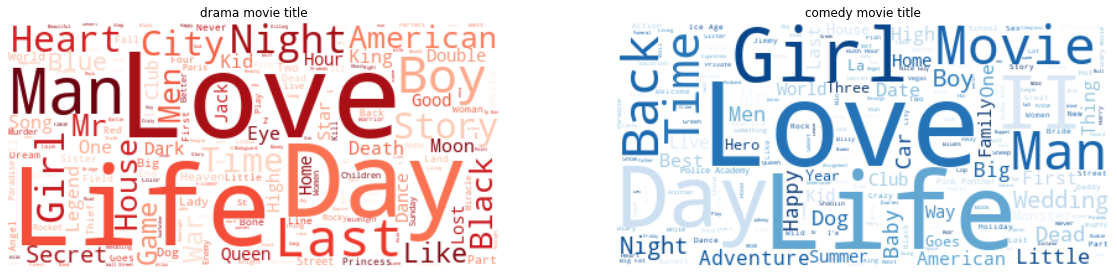

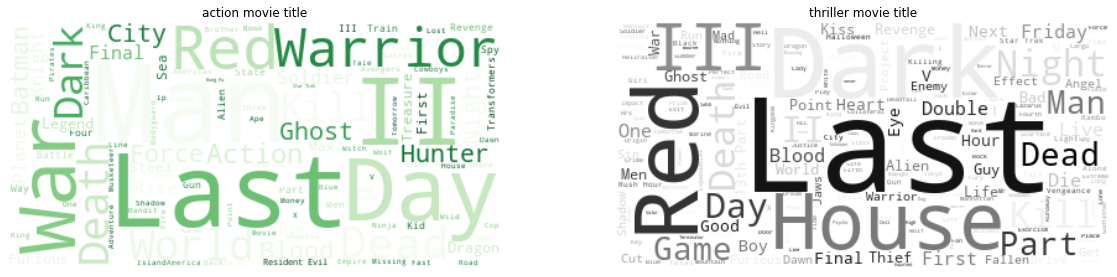

In [ ]:
# Text analysis on top 4 movie genres title 

drama=train.loc[train['genre_Drama']==1,]
comedy=train.loc[train['genre_Comedy']==1,]
action=train.loc[train['genre_Action']==1,]
thriller=train.loc[train['genre_Thriller']==1,]



text_drama = " ".join(review for review in drama.title)
text_comedy = " ".join(review for review in comedy.title)
text_action = " ".join(review for review in action.title)
text_thriller = " ".join(review for review in thriller.title)


wordcloud1 = WordCloud(stopwords=stopwords, background_color="white",colormap="Reds").generate(text_drama)
wordcloud2 = WordCloud(stopwords=stopwords, background_color="white",colormap="Blues").generate(text_comedy)
wordcloud3 = WordCloud(stopwords=stopwords, background_color="white",colormap="Greens").generate(text_action)
wordcloud4 = WordCloud(stopwords=stopwords, background_color="white",colormap="Greys").generate(text_thriller)


fig = plt.figure(figsize=(20, 10))

plt.subplot(221)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('drama movie title')
plt.axis("off")

plt.subplot(222)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('comedy movie title')
plt.axis("off")
plt.show()

fig = plt.figure(figsize=(20, 10))

plt.subplot(223)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.title('action movie title')
plt.axis("off")

plt.subplot(224)
plt.imshow(wordcloud4, interpolation='bilinear')
plt.title('thriller movie title')
plt.axis("off")
plt.show()


In [ ]:
drama_revenue=drama.groupby(['release_year']).mean()['revenue']
comedy_revenue=comedy.groupby(['release_year']).mean()['revenue']
action_revenue=action_revenue=action.groupby(['release_year']).mean()['revenue']
thriller_revenue=thriller.groupby(['release_year']).mean()['revenue']

revenue_concat = pd.concat([drama_revenue,comedy_revenue,action_revenue,thriller_revenue], axis=1)
revenue_concat.columns=['drama','comedy','action','thriller']
revenue_concat.index=train.groupby(['release_year']).mean().index

In [ ]:
# Mean revenue over years by top 4 genres 
import plotly.graph_objs as go
import plotly.offline as py
data = [go.Scatter(x=revenue_concat.index, y=revenue_concat.drama, name='drama'), go.Scatter(x=revenue_concat.index, y=revenue_concat.comedy, name='comedy'),
       go.Scatter(x=revenue_concat.index, y=revenue_concat.action, name='action'),go.Scatter(x=revenue_concat.index, y=revenue_concat.thriller, name='thriller')]
layout = go.Layout(dict(title = 'Mean Revenue by Top 4 Movie Genres Over Years',
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Revenue'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

## **Production Companies**

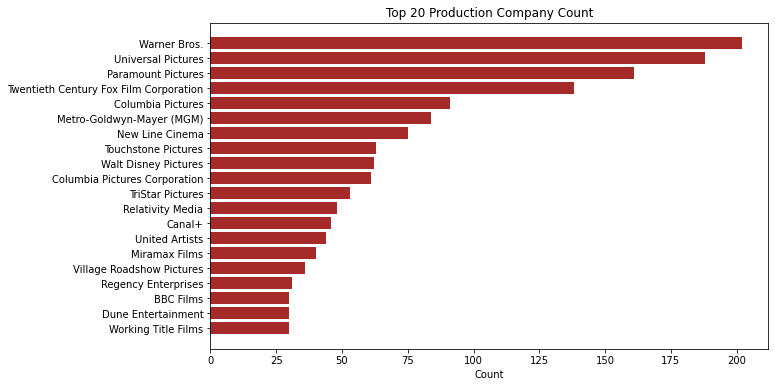

In [ ]:
# Counting the frequency of production company 
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

most_common_companies=Counter([i for j in list_of_companies for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_companies)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='brown')
plt.xlabel('Count')
plt.title('Top 20 Production Company Count')
plt.show()


In [ ]:
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)

## **Production Countries**

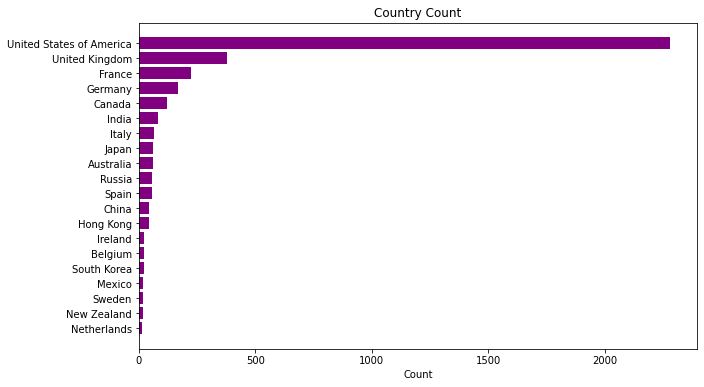

In [ ]:
list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
most_common_countries=Counter([i for j in list_of_countries for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_countries)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='purple')
plt.xlabel('Count')
plt.title('Country Count')
plt.show()

In [ ]:
train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train['production_country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)
    
test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test['production_country_' + g] = test['all_countries'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_countries', 'all_countries'], axis=1)
test = test.drop(['production_countries', 'all_countries'], axis=1)

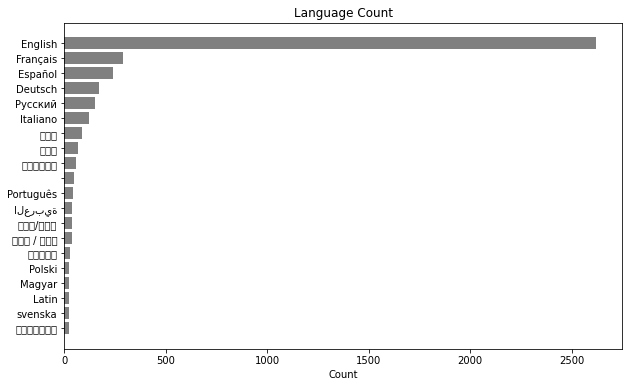

In [ ]:
# English is the majority spoken language 
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

most_common_languages=Counter([i for j in list_of_languages for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_languages)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='gray')
plt.xlabel('Count')
plt.title('Language Count')
plt.show()

In [ ]:
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['iso_639_1'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['iso_639_1'] for i in x])) if x != {} else '')
for g in top_languages:
    test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['spoken_languages', 'all_languages'], axis=1)
test = test.drop(['spoken_languages', 'all_languages'], axis=1)

## **Keywords**

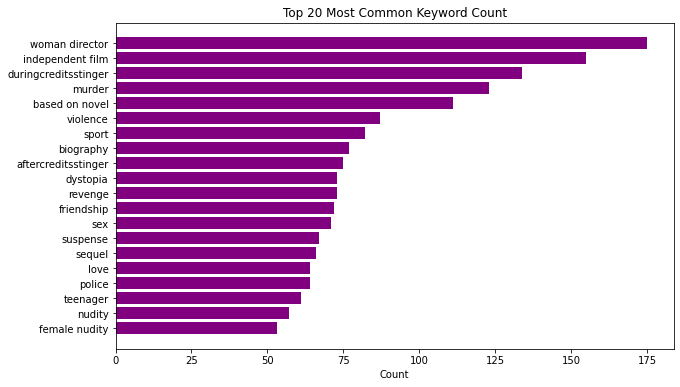

In [ ]:
list_of_keywords = list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

most_common_keywords=Counter([i for j in list_of_keywords for i in j]).most_common(20)

fig = plt.figure(figsize=(10, 6))
data=dict(most_common_keywords)
names = list(data.keys())
values = list(data.values())

plt.barh(sorted(range(len(data)),reverse=True),values,tick_label=names,color='purple')
plt.xlabel('Count')
plt.title('Top 20 Most Common Keyword Count')
plt.show()


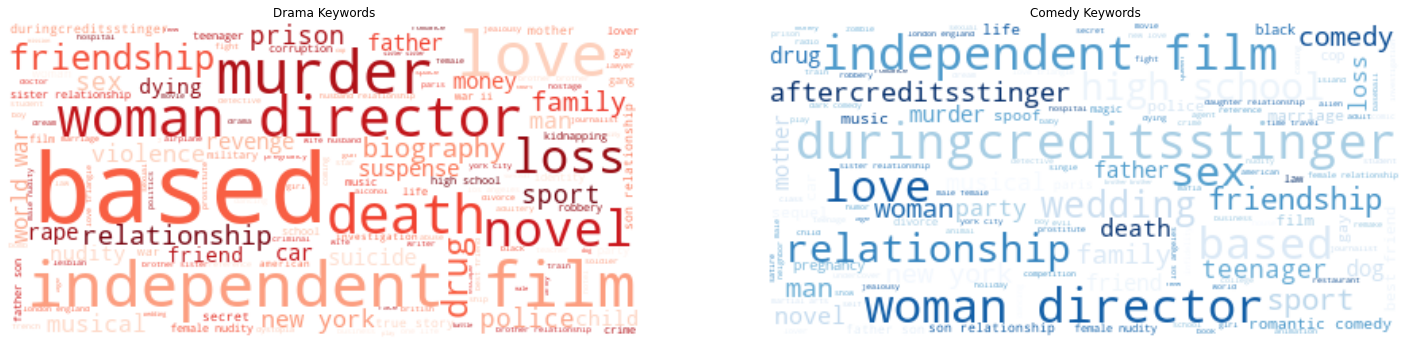

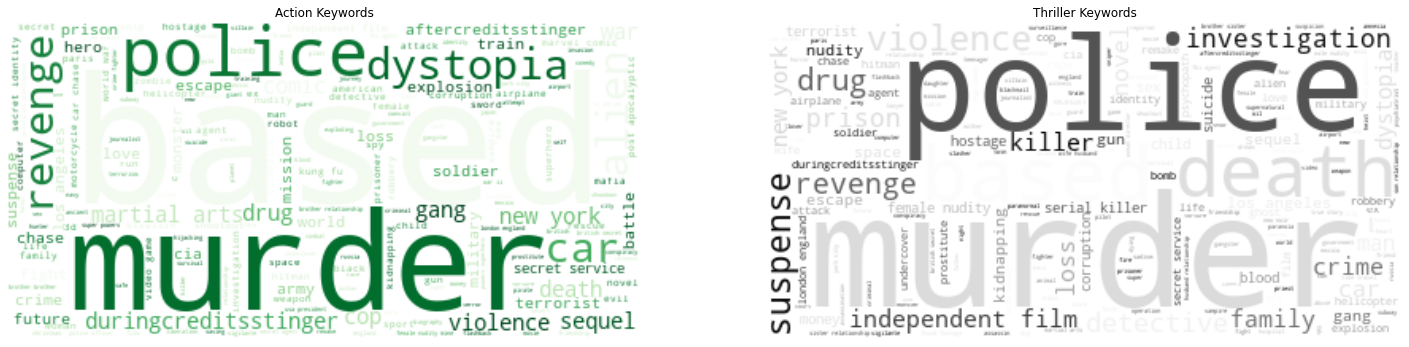

In [ ]:
# Text analysis on keywords by top 4 genres


text_drama = " ".join(review for review in drama['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else ''))
text_comedy = " ".join(review for review in comedy['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else ''))
text_action = " ".join(review for review in action['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else ''))
text_thriller = " ".join(review for review in thriller['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else ''))


wordcloud1 = WordCloud(stopwords=stopwords, background_color="white",colormap="Reds").generate(text_drama)
wordcloud2 = WordCloud(stopwords=stopwords, background_color="white",colormap="Blues").generate(text_comedy)
wordcloud3 = WordCloud(stopwords=stopwords, background_color="white",colormap="Greens").generate(text_action)
wordcloud4 = WordCloud(stopwords=stopwords, background_color="white",colormap="Greys").generate(text_thriller)


fig = plt.figure(figsize=(25, 20))

plt.subplot(221)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Drama Keywords')
plt.axis("off")

plt.subplot(222)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Comedy Keywords')
plt.axis("off")
plt.show()

fig = plt.figure(figsize=(25, 20))

plt.subplot(223)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.title('Action Keywords')
plt.axis("off")

plt.subplot(224)
plt.imshow(wordcloud4, interpolation='bilinear')
plt.title('Thriller Keywords')
plt.axis("off")
plt.show()

In [ ]:
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)

## **Cast**

In [ ]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
train['all_cast'] = train['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(30)]
for g in top_cast_names:
    train['cast_name_' + g] = train['all_cast'].apply(lambda x: 1 if g in x else 0)

    
test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
test['all_cast'] = test['cast'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_cast_names:
    test['cast_name_' + g] = test['all_cast'].apply(lambda x: 1 if g in x else 0)

Text(0.5, 0, 'Revenue (100 million dollars)')

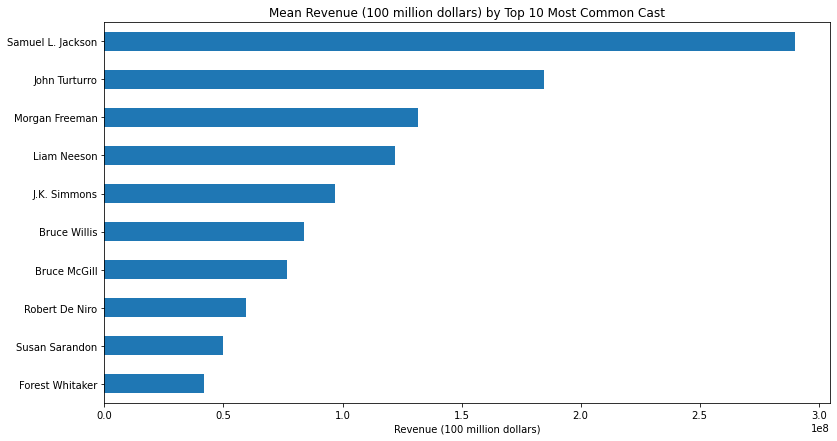

In [ ]:
#Mean revenue comparison of 10 most common actor/actress 

cast_name_Samuel_L_Jackson=train.loc[train['cast_name_Samuel L. Jackson']==1,]
cast_name_Robert_De_Niro=train.loc[train['cast_name_Robert De Niro']==1,]
cast_name_Morgan_Freeman=train.loc[train['cast_name_Morgan Freeman']==1,]
cast_name_J_K_Simmons=train.loc[train['cast_name_J.K. Simmons']==1,]
cast_name_Bruce_Willis=train.loc[train['cast_name_Bruce Willis']==1,]
cast_name_Liam_Neeson=train.loc[train['cast_name_Liam Neeson']==1,]
cast_name_Susan_Sarandon=train.loc[train['cast_name_Susan Sarandon']==1,]
cast_name_Bruce_McGill=train.loc[train['cast_name_Bruce McGill']==1,]
cast_name_John_Turturro=train.loc[train['cast_name_John Turturro']==1,]
cast_name_Forest_Whitaker=train.loc[train['cast_name_Forest Whitaker']==1,]


cast_name_Samuel_L_Jackson_revenue=cast_name_Samuel_L_Jackson.mean()['revenue']
cast_name_Robert_De_Niro_revenue=cast_name_Robert_De_Niro.mean()['revenue']
cast_name_Morgan_Freeman_revenue=cast_name_Morgan_Freeman.mean()['revenue']
cast_name_J_K_Simmons_revenue=cast_name_J_K_Simmons.mean()['revenue']
cast_name_Bruce_Willis_revenue=cast_name_Bruce_Willis.mean()['revenue']
cast_name_Liam_Neeson_revenue=cast_name_Liam_Neeson.mean()['revenue']
cast_name_Susan_Sarandon_revenue=cast_name_Susan_Sarandon.mean()['revenue']
cast_name_Bruce_McGill_revenue=cast_name_Bruce_McGill.mean()['revenue']
cast_name_John_Turturro_revenue=cast_name_John_Turturro.mean()['revenue']
cast_name_Forest_Whitaker_revenue=cast_name_Forest_Whitaker.mean()['revenue']


cast_revenue_concat = pd.Series([cast_name_Samuel_L_Jackson_revenue,cast_name_Robert_De_Niro_revenue,cast_name_Morgan_Freeman_revenue,cast_name_J_K_Simmons_revenue,
                                cast_name_Bruce_Willis_revenue,cast_name_Liam_Neeson_revenue,cast_name_Susan_Sarandon_revenue,cast_name_Bruce_McGill_revenue,
                                cast_name_John_Turturro_revenue,cast_name_Forest_Whitaker_revenue])
cast_revenue_concat.index=['Samuel L. Jackson','Robert De Niro','Morgan Freeman','J.K. Simmons','Bruce Willis','Liam Neeson','Susan Sarandon','Bruce McGill',
                            'John Turturro','Forest Whitaker']


fig = plt.figure(figsize=(13, 7))
cast_revenue_concat.sort_values(ascending=True).plot(kind='barh',title='Mean Revenue (100 million dollars) by Top 10 Most Common Cast')
plt.xlabel('Revenue (100 million dollars)')

In [ ]:
# Consider other factors like gender and characters 

list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)


train['genders_0'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['cast_character_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
    

test['genders_0'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['cast_character_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)

train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

## **Crew**

In [ ]:
list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
train['all_crew'] = train['crew'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(30)]
for g in top_crew_names:
    train['crew_name_' + g] = train['all_crew'].apply(lambda x: 1 if g in x else 0)

test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
test['all_crew'] = test['crew'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_crew_names:
    test['crew_name_' + g] = test['all_crew'].apply(lambda x: 1 if g in x else 0)

Text(0.5, 0, 'Revenue (100 million dollars)')

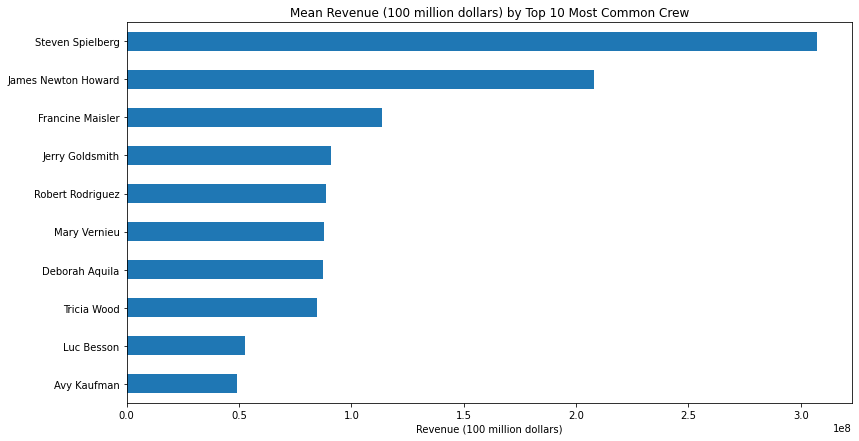

In [ ]:
crew_name_Avy_Kaufman=train.loc[train['crew_name_Avy Kaufman']==1,]
crew_name_Robert_Rodriguez=train.loc[train['crew_name_Robert Rodriguez']==1,]
crew_name_Deborah_Aquila=train.loc[train['crew_name_Deborah Aquila']==1,]
crew_name_James_Newton_Howard=train.loc[train['crew_name_James Newton Howard']==1,]
crew_name_Mary_Vernieu=train.loc[train['crew_name_Mary Vernieu']==1,]
crew_name_Steven_Spielberg=train.loc[train['crew_name_Steven Spielberg']==1,]
crew_name_Luc_Besson=train.loc[train['crew_name_Luc Besson']==1,]
crew_name_Jerry_Goldsmith=train.loc[train['crew_name_Jerry Goldsmith']==1,]
crew_name_Francine_Maisler=train.loc[train['crew_name_Francine Maisler']==1,]
crew_name_Tricia_Wood=train.loc[train['crew_name_Tricia Wood']==1,]


crew_name_Avy_Kaufman_revenue=crew_name_Avy_Kaufman.mean()['revenue']
crew_name_Robert_Rodriguez_revenue=crew_name_Robert_Rodriguez.mean()['revenue']
crew_name_Deborah_Aquila_revenue=crew_name_Deborah_Aquila.mean()['revenue']
crew_name_James_Newton_Howard_revenue=crew_name_James_Newton_Howard.mean()['revenue']
crew_name_Mary_Vernieu_revenue=crew_name_Mary_Vernieu.mean()['revenue']
crew_name_Steven_Spielberg_revenue=crew_name_Steven_Spielberg.mean()['revenue']
crew_name_Luc_Besson_revenue=crew_name_Luc_Besson.mean()['revenue']
crew_name_Jerry_Goldsmith_revenue=crew_name_Jerry_Goldsmith.mean()['revenue']
crew_name_Francine_Maisler_revenue=crew_name_Francine_Maisler.mean()['revenue']
crew_name_Tricia_Wood_revenue=crew_name_Tricia_Wood.mean()['revenue']


crew_revenue_concat = pd.Series([crew_name_Avy_Kaufman_revenue,crew_name_Robert_Rodriguez_revenue,crew_name_Deborah_Aquila_revenue,crew_name_James_Newton_Howard_revenue,
                                crew_name_Mary_Vernieu_revenue,crew_name_Steven_Spielberg_revenue,crew_name_Luc_Besson_revenue,crew_name_Jerry_Goldsmith_revenue,
                                crew_name_Francine_Maisler_revenue,crew_name_Tricia_Wood_revenue])
crew_revenue_concat.index=['Avy Kaufman','Robert Rodriguez','Deborah Aquila','James Newton Howard','Mary Vernieu','Steven Spielberg','Luc Besson','Jerry Goldsmith',
                            'Francine Maisler','Tricia Wood']


fig = plt.figure(figsize=(13, 7))
crew_revenue_concat.sort_values(ascending=True).plot(kind='barh',title='Mean Revenue (100 million dollars) by Top 10 Most Common Crew')
plt.xlabel('Revenue (100 million dollars)')

In [ ]:
# Consider other factors like crew jobs, gender, and department 

list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)


train['genders_0'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['crew_character_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    

    
test['genders_0'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['crew_character_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
for j in top_crew_jobs:
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
for j in top_crew_departments:
    test['departments_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

# **Feature Engineering**

Skew of revenue attribute: 4.5


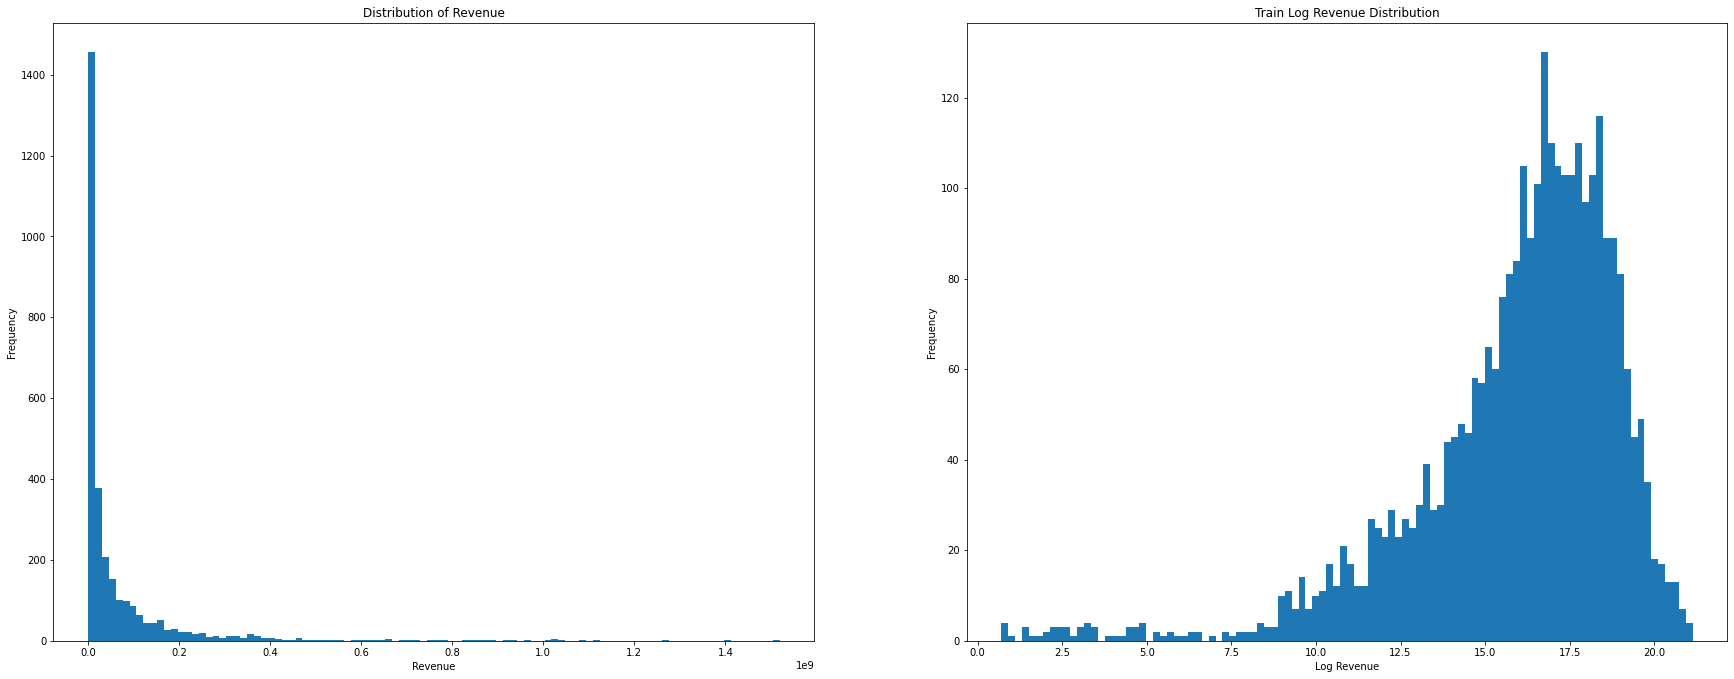

In [ ]:
# Plot the distribution of the revenue

fig = plt.figure(figsize=(30, 25))

plt.subplot(221)
train['revenue'].plot(kind='hist',bins=100)
plt.title('Distribution of Revenue')
plt.xlabel('Revenue')

plt.subplot(222)
np.log1p(train['revenue']).plot(kind='hist',bins=100)
plt.title('Train Log Revenue Distribution')
plt.xlabel('Log Revenue')


print('Skew of revenue attribute: %0.1f' % skew(train['revenue']))

In [ ]:
# Adjusting other skewed variables such as popularity and budget

print('Skew of train budget attribute: %0.1f' % skew(train['budget']))
print('Skew of test budget attribute: %0.1f' % skew(test['budget']))
print('Skew of train popularity attribute: %0.1f' % skew(train['popularity']))
print('Skew of test popularity attribute: %0.1f' % skew(test['popularity']))

Skew of train budget attribute: 3.1
Skew of test budget attribute: 2.7
Skew of train popularity attribute: 14.4
Skew of test popularity attribute: 23.7


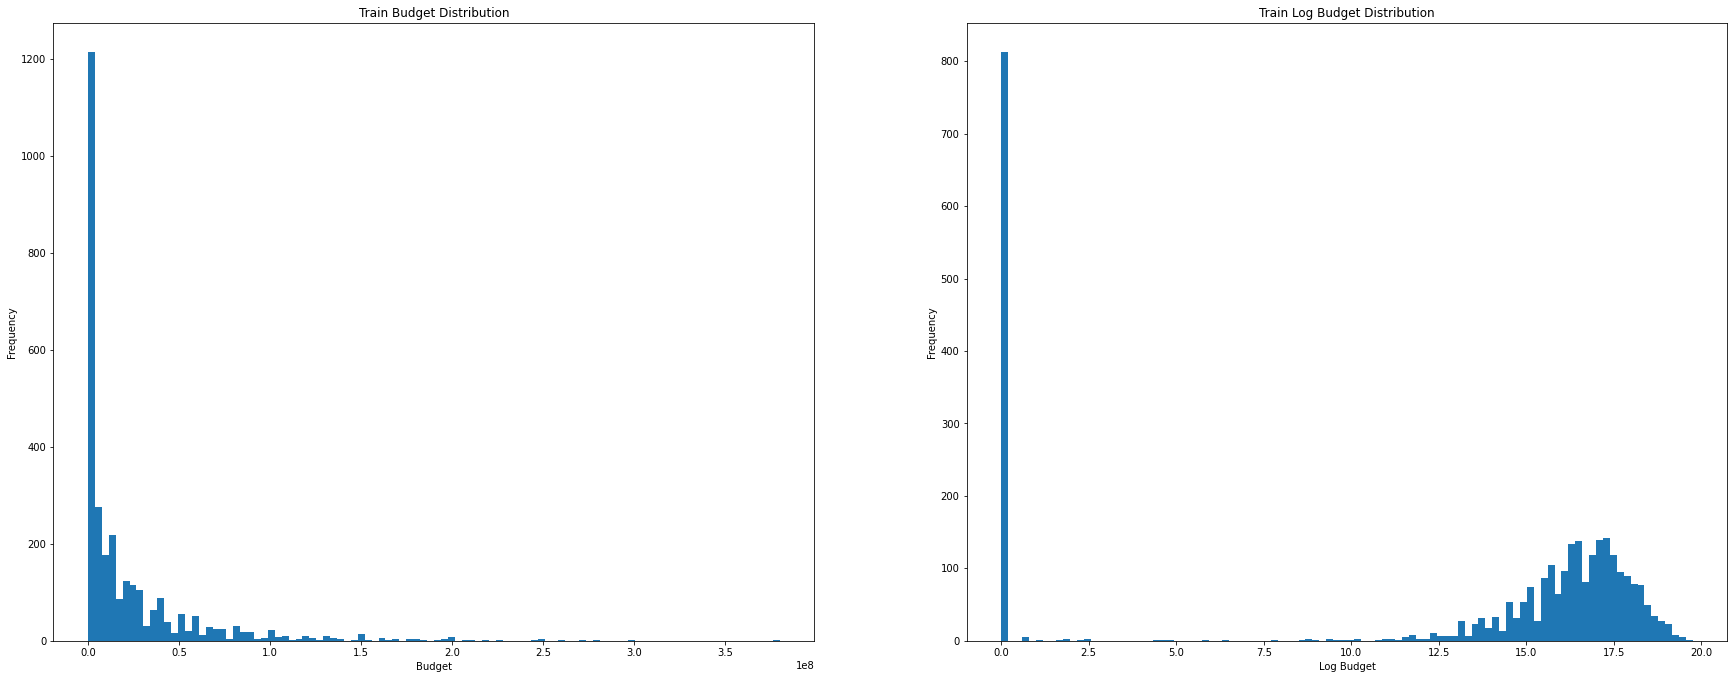

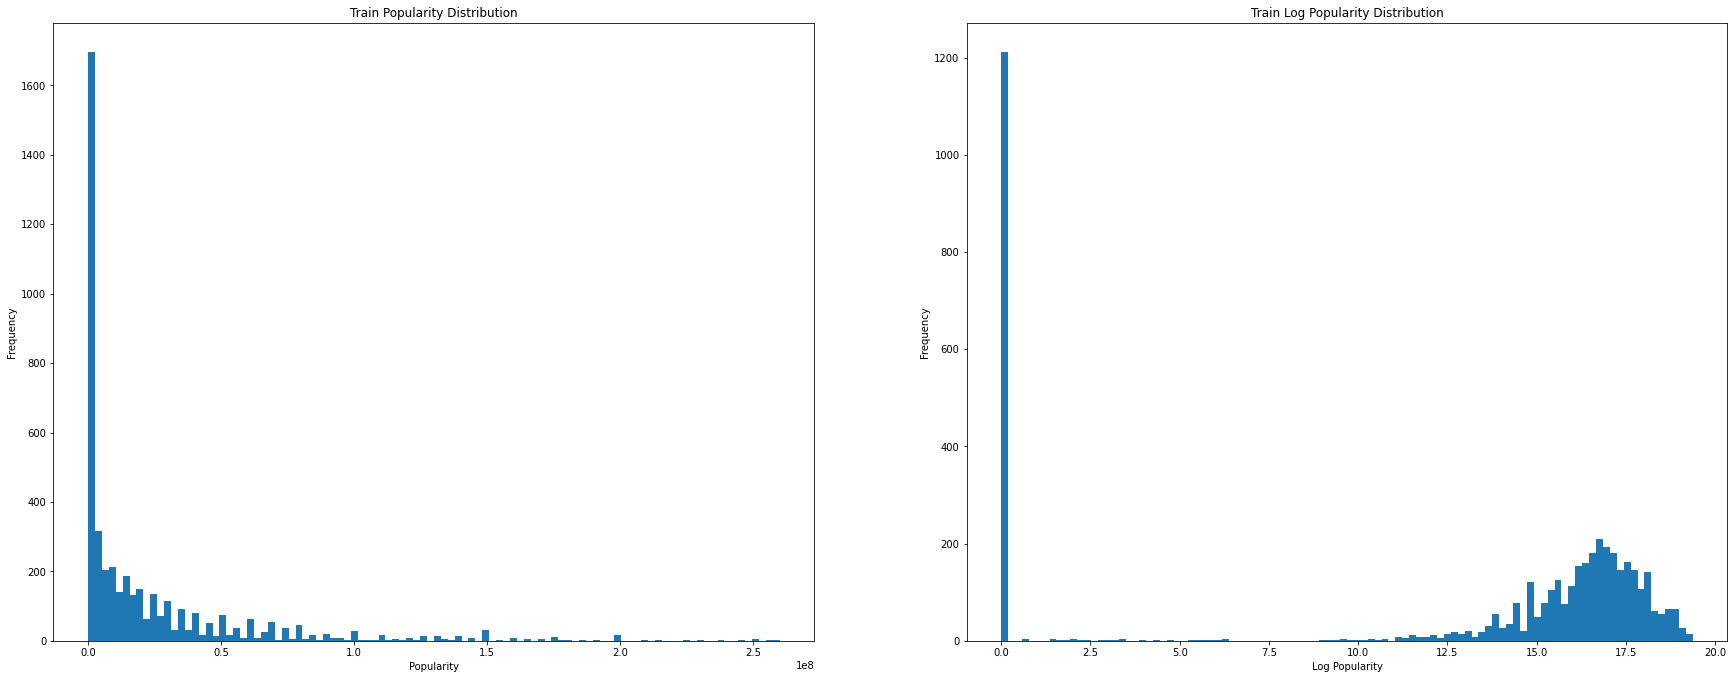

In [ ]:
# Before log transformation and after log transformation for train budget and train popularity 
fig = plt.figure(figsize=(30, 25))

plt.subplot(221)
train['budget'].plot(kind='hist',bins=100)
plt.title('Train Budget Distribution')
plt.xlabel('Budget')

plt.subplot(222)
np.log1p(train['budget']).plot(kind='hist',bins=100)
plt.title('Train Log Budget Distribution')
plt.xlabel('Log Budget')

plt.show()

fig = plt.figure(figsize=(30, 25))

plt.subplot(223)
test['budget'].plot(kind='hist',bins=100)
plt.title('Train Popularity Distribution')
plt.xlabel('Popularity')

plt.subplot(224)
np.log1p(test['budget']).plot(kind='hist',bins=100)
plt.title('Train Log Popularity Distribution')
plt.xlabel('Log Popularity')
plt.show()


In [ ]:
# Revising budget variable 

power_six = train.id[train.budget > 1000][train.revenue < 100]

for k in power_six :
    train.loc[train['id'] == k,'revenue'] =  train.loc[train['id'] == k,'revenue'] * 1000000

In [ ]:
# Putting log variables for skewed data 
train['log_budget']=np.log1p(train['budget'])
test['log_budget']=np.log1p(test['budget'])
train['log_popularity']=np.log1p(train['popularity'])
test['log_popularity']=np.log1p(test['popularity'])

In [ ]:
def prepare(df):
    df['_budget_runtime_ratio'] = df['budget']/df['runtime'] 
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget']/(df['release_year']*df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']
    df['_year_to_log_budget'] = df['release_year'] / df['log_budget']
    df['_year_to_log_popularity'] = df['release_year'] / df['log_popularity']

    df['has_homepage'] = 0
    df.loc[pd.isnull(df['homepage']) ,"has_homepage"] = 1
    
    df['isTaglineNA'] = 0
    df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1 
    
    df['isTitleDifferent'] = 1
    df.loc[ df['original_title'] == df['title'] ,"isTitleDifferent"] = 0 

    df['isMovieReleased'] = 1
    df.loc[ df['status'] != "Released" ,"isMovieReleased"] = 0 

    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len() 
    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()
    df['meanruntimeByYear'] = df.groupby("release_year")["runtime"].aggregate('mean')
    df['meanPopularityByYear'] = df.groupby("release_year")["popularity"].aggregate('mean')
    df['meanBudgetByYear'] = df.groupby("release_year")["budget"].aggregate('mean')

    return df

train_new=prepare(train)
test_new=prepare(test)


In [ ]:
train_new.to_csv("train_new.csv", index=False)
test_new.to_csv("test_new.csv", index=False)

In [ ]:
drop_columns=['homepage','imdb_id','poster_path','status','title', 'release_date','tagline', 'overview', 'original_title','all_genres','all_cast',
             'original_language','collection_name','all_crew']
train_new=train_new.drop(drop_columns,axis=1)
test_new=test_new.drop(drop_columns,axis=1)

In [ ]:
train_new.head(1)

,id,budget,popularity,runtime,revenue,release_year,release_month,release_day,release_quarter,release_dow,...,isTitleDifferent,isMovieReleased,original_title_letter_count,original_title_word_count,title_word_count,overview_word_count,tagline_word_count,meanruntimeByYear,meanPopularityByYear,meanBudgetByYear
0,1,14000000,6.575393,93.0,12314651,2015,2,20,1,4,...,0,1,22,5,5,29.0,11.0,NaN,NaN,NaN


In [ ]:
print( "updated train dataset:", train_new.shape,"\n","updated test dataset: ",test_new.shape)

# Just double checking the difference of variables between train and test 
print(train_new.columns.difference(test_new.columns)) # good to go! 

updated train dataset: (3000, 289) 
 updated test dataset:  (4398, 288)
Index(['revenue'], dtype='object')


In [ ]:
# Formating for modeling
from sklearn.model_selection import train_test_split
X = train_new.drop(['id','revenue'], axis=1)
y = np.log1p(train_new['revenue'])
X_test = test_new.drop(['id'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}

lgb_model = lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)
lgb_model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

#eli5.show_weights(lgb_model, feature_filter=lambda x: x != '<BIAS>')

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[671]	training's rmse: 1.42002	valid_1's rmse: 2.11807


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', feature_fraction=0.9, lambda_l1=0.2,
              learning_rate=0.01, max_depth=5, metric='rmse',
              min_data_in_leaf=20, n_estimators=10000, nthread=4, num_leaves=30,
              objective='regression', verbosity=-1)

In [ ]:
# Obtain from Random Search 

opt_parameters = {'random_state': 501, 'objective': 'regression', 'num_leaves': 40, 'min_data_in_leaf': 15, 'max_depth': 4, 'learning_rate': 0.01, 'boosting_type': 'gbdt'} 

params['learning_rate'] = opt_parameters['learning_rate']
params['max_depth'] = opt_parameters['max_depth']
params['num_leaves'] = opt_parameters['num_leaves']
params['min_data_in_leaf'] = opt_parameters['min_data_in_leaf']

In [ ]:
n_fold = 5
random_seed=2222
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=True, model=None):

    oof = np.zeros(X.shape[0])
    prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=500, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=10000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [ ]:
import time
from sklearn.metrics import mean_squared_error

Fold 0 started at Sun Aug 21 22:22:36 2022
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.68391	valid_1's rmse: 1.91704
[1000]	training's rmse: 1.50642	valid_1's rmse: 1.88139
[1500]	training's rmse: 1.36399	valid_1's rmse: 1.86856
Early stopping, best iteration is:
[1726]	training's rmse: 1.30879	valid_1's rmse: 1.86672
Fold 1 started at Sun Aug 21 22:22:39 2022
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.71444	valid_1's rmse: 1.88089
[1000]	training's rmse: 1.53412	valid_1's rmse: 1.83991
[1500]	training's rmse: 1.39828	valid_1's rmse: 1.82748
[2000]	training's rmse: 1.28184	valid_1's rmse: 1.8227
[2500]	training's rmse: 1.17979	valid_1's rmse: 1.8223
Early stopping, best iteration is:
[2327]	training's rmse: 1.21329	valid_1's rmse: 1.82103
Fold 2 started at Sun Aug 21 22:22:44 2022
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.70899	valid_1's rmse: 1.89269
[

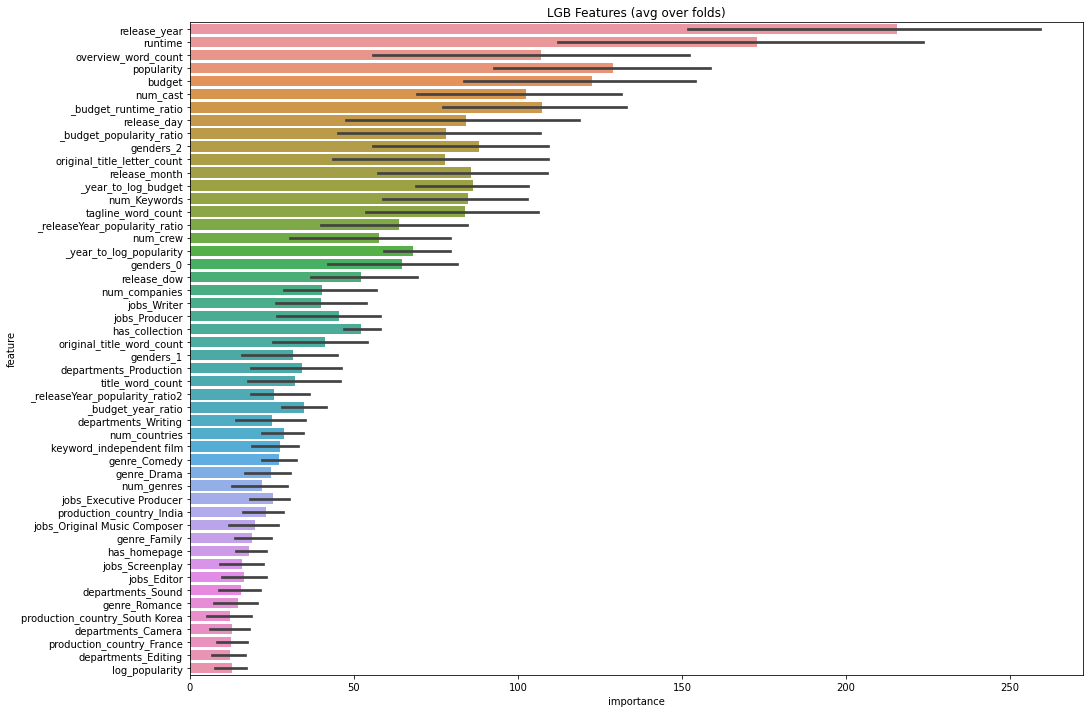

In [ ]:
oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=params, model_type='lgb')


In [ ]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 6,
              'min_child_weight': 3,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}

start = time.time()
oof_xgb, prediction_xgb = train_model(X, X_test, y, params=xgb_params, model_type='xgb')
end = time.time()
print("time elapsed:",end - start, "second")

Fold 0 started at Sun Aug 21 22:22:54 2022
[0]	train-rmse:15.5961	valid_data-rmse:15.76
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.22072	valid_data-rmse:1.90084
[1000]	train-rmse:0.88377	valid_data-rmse:1.87603
[1500]	train-rmse:0.667985	valid_data-rmse:1.87525
Stopping. Best iteration:
[1306]	train-rmse:0.748734	valid_data-rmse:1.87441

Fold 1 started at Sun Aug 21 22:23:31 2022
[0]	train-rmse:15.6399	valid_data-rmse:15.585
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.24188	valid_data-rmse:1.87651
[1000]	train-rmse:0.922231	valid_data-rmse:1.84189
[1500]	train-rmse:0.7004	valid_data-rmse:1.83285
Stopping. Best iteration:
[1538]	train-rmse:0.686881	valid_data-rmse:1.83238

Fold 2 started at Sun Aug 21 22:24:13 2022
[0]	train-rms

In [ ]:
sam_sub =pd.read_csv(result_url)

In [ ]:
sam_sub['revenue'] = np.expm1(prediction_lgb)
sam_sub.to_csv("lgb.csv", index=False)
sam_sub['revenue'] = np.expm1(prediction_xgb)
sam_sub.to_csv("xgb.csv", index=False)
sam_sub['revenue'] = np.expm1((prediction_lgb + prediction_xgb) / 2)
sam_sub.to_csv("blend_lgb_xgb.csv", index=False)